# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


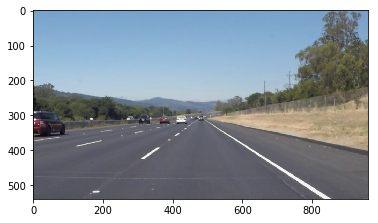

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [27]:
import math
from numpy import median , mean
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    s1x1 = []
    s1y1 = []
    s1x2 = []
    s1y2 = []
    s2x1 = []
    s2y1 = []
    s2x2 = []
    s2y2 = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            s = (y2-y1)/(x2-x1)
            #print(s)
        if s>0:
            s1x1.append(x1)
            s1y1.append(y1)
            s1x2.append(x2)
            s1y2.append(y2)
        else:
            s2x1.append(x1)
            s2y1.append(y1)
            s2x2.append(x2)
            s2y2.append(y2)
    lines1=[]
    lines1=[[[int(median(s1x1)),int(median(s1y1)),int(median(s1x2)),int(median(s1y2))]],[[int(median(s2x1)),int(median(s2y1)),int(median(s2x2)),int(median(s2y2))]]]
    print(lines1)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [28]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'white1.JPG',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

[[[507, 324, 877, 538]], [[294, 449, 462, 323]]]


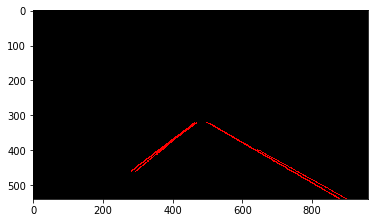

In [29]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.
#reading in an image
image = mpimg.imread('test_images/solidWhiteCurve.jpg')
gimage = grayscale(image)
gauss = gaussian_blur(gimage,5)
img_canny = canny(gauss,50,150)
size = image.shape
vertices = np.array([[(50,540),(900,540),(500,320),(450,320)]], dtype=np.int32)
mask = region_of_interest(img_canny,vertices)
hough1 = hough_lines(mask,1,1*(np.pi/180),30,5,180)
weigh = weighted_img(hough1,image)
plt.imshow(hough1,cmap='Greys')

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [7]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    gimage = grayscale(image)
    gauss = gaussian_blur(gimage,5)
    img_canny = canny(gauss,50,150)
    size = image.shape
    vertices = np.array([[(50,540),(900,540),(500,320),(450,320)]], dtype=np.int32)
    mask = region_of_interest(img_canny,vertices)
    hough1 = hough_lines(mask,1,1*(np.pi/180),30,10,180)
    weigh = weighted_img(hough1,image)
    return weigh

Let's try the one with the solid white lane on the right first ...

In [8]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[[[587, 372, 810, 515]], [[198, 514, 457, 320]]]
[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


  0%|                                                                                          | 0/222 [00:00<?, ?it/s]

[[[587, 372, 810, 515]], [[198, 514, 457, 320]]]
[[[570, 358, 845, 537]], [[170, 538, 454, 322]]]
[[[587, 368, 842, 535]], [[190, 523, 453, 323]]]


  1%|█                                                                                 | 3/222 [00:00<00:08, 26.88it/s]

[[[557, 351, 844, 536]], [[169, 538, 456, 322]]]
[[[520, 331, 849, 538]], [[167, 532, 456, 320]]]
[[[565, 355, 819, 519]], [[291, 442, 455, 320]]]


  3%|██▏                                                                               | 6/222 [00:00<00:07, 27.51it/s]

[[[572, 359, 859, 538]], [[259, 462, 455, 320]]]
[[[571, 359, 851, 538]], [[221, 488, 458, 320]]]
[[[559, 352, 849, 538]], [[166, 525, 456, 320]]]


  4%|███▎                                                                              | 9/222 [00:00<00:07, 27.78it/s]

[[[530, 336, 843, 537]], [[293, 439, 460, 320]]]
[[[518, 331, 817, 521]], [[267, 460, 463, 320]]]
[[[545, 351, 818, 529]], [[235, 483, 464, 320]]]


  5%|████▍                                                                            | 12/222 [00:00<00:07, 28.20it/s]

[[[510, 325, 829, 533]], [[195, 514, 457, 321]]]
[[[524, 333, 833, 538]], [[145, 538, 454, 321]]]
[[[546, 345, 835, 538]], [[152, 538, 448, 326]]]


  7%|█████▍                                                                           | 15/222 [00:00<00:07, 28.19it/s]

[[[577, 362, 836, 532]], [[157, 538, 451, 320]]]
[[[576, 363, 820, 527]], [[156, 538, 449, 325]]]
[[[568, 357, 825, 532]], [[287, 439, 453, 320]]]
[[[553, 349, 809, 521]], [[262, 457, 455, 320]]]


  9%|██████▉                                                                          | 19/222 [00:00<00:06, 29.35it/s]

[[[519, 333, 817, 527]], [[234, 485, 458, 322]]]
[[[524, 333, 832, 538]], [[188, 520, 463, 320]]]
[[[524, 333, 797, 504]], [[294, 439, 461, 320]]]


 10%|████████                                                                         | 22/222 [00:00<00:06, 29.45it/s]

[[[513, 327, 828, 534]], [[265, 456, 463, 320]]]
[[[534, 343, 833, 538]], [[232, 477, 456, 320]]]
[[[537, 340, 834, 538]], [[188, 509, 456, 320]]]


 11%|█████████                                                                        | 25/222 [00:00<00:06, 28.55it/s]

[[[540, 342, 832, 537]], [[163, 537, 452, 322]]]
[[[540, 342, 829, 535]], [[164, 527, 449, 327]]]
[[[537, 340, 833, 538]], [[180, 520, 456, 320]]]


 13%|██████████▏                                                                      | 28/222 [00:00<00:06, 27.99it/s]

[[[537, 340, 807, 520]], [[171, 527, 458, 320]]]
[[[543, 343, 834, 537]], [[285, 439, 454, 322]]]
[[[544, 344, 836, 538]], [[264, 458, 455, 320]]]


 14%|███████████▎                                                                     | 31/222 [00:01<00:07, 27.05it/s]

[[[548, 348, 837, 538]], [[229, 485, 455, 320]]]
[[[555, 350, 836, 538]], [[166, 518, 458, 322]]]
[[[546, 347, 836, 538]], [[299, 436, 455, 320]]]


 15%|████████████▍                                                                    | 34/222 [00:01<00:07, 26.68it/s]

[[[546, 345, 834, 538]], [[283, 450, 450, 325]]]
[[[550, 349, 833, 538]], [[245, 477, 456, 320]]]
[[[543, 346, 826, 528]], [[207, 508, 453, 324]]]


 17%|█████████████▌                                                                   | 37/222 [00:01<00:06, 26.53it/s]

[[[547, 347, 832, 537]], [[157, 538, 455, 322]]]
[[[546, 345, 756, 489]], [[211, 501, 456, 320]]]
[[[549, 348, 833, 538]], [[163, 538, 397, 367]]]


 18%|██████████████▌                                                                  | 40/222 [00:01<00:06, 27.25it/s]

[[[566, 357, 833, 538]], [[165, 524, 456, 320]]]
[[[572, 361, 832, 538]], [[297, 440, 456, 320]]]
[[[551, 349, 809, 523]], [[266, 459, 446, 325]]]


 19%|███████████████▋                                                                 | 43/222 [00:01<00:06, 27.40it/s]

[[[544, 345, 825, 534]], [[285, 445, 454, 320]]]
[[[542, 344, 831, 538]], [[185, 515, 454, 320]]]
[[[560, 353, 820, 530]], [[304, 432, 453, 321]]]


 21%|████████████████▊                                                                | 46/222 [00:01<00:06, 27.50it/s]

[[[559, 352, 832, 537]], [[281, 449, 452, 321]]]
[[[542, 344, 732, 473]], [[241, 470, 452, 320]]]
[[[530, 337, 804, 521]], [[205, 499, 453, 320]]]


 22%|█████████████████▉                                                               | 49/222 [00:01<00:09, 18.89it/s]

[[[535, 340, 830, 538]], [[162, 537, 450, 323]]]
[[[550, 349, 796, 516]], [[160, 538, 439, 329]]]
[[[557, 351, 831, 538]], [[158, 538, 419, 342]]]


 23%|██████████████████▉                                                              | 52/222 [00:02<00:09, 18.19it/s]

[[[554, 351, 822, 532]], [[156, 537, 456, 320]]]
[[[548, 346, 825, 533]], [[289, 437, 455, 320]]]
[[[549, 347, 784, 500]], [[259, 455, 454, 320]]]


 25%|████████████████████                                                             | 55/222 [00:02<00:09, 16.75it/s]

[[[537, 340, 747, 471]], [[223, 480, 454, 320]]]
[[[515, 328, 792, 506]], [[250, 466, 456, 320]]]
[[[508, 324, 828, 538]], [[290, 436, 459, 320]]]


 26%|█████████████████████▏                                                           | 58/222 [00:02<00:08, 18.45it/s]

[[[505, 323, 774, 503]], [[263, 454, 456, 320]]]
[[[510, 325, 769, 501]], [[232, 475, 448, 324]]]
[[[517, 329, 824, 529]], [[194, 506, 439, 332]]]


 27%|██████████████████████▎                                                          | 61/222 [00:02<00:08, 19.42it/s]

[[[537, 344, 823, 538]], [[143, 537, 452, 324]]]
[[[536, 343, 812, 525]], [[151, 538, 456, 322]]]
[[[508, 324, 783, 499]], [[150, 538, 455, 320]]]


 29%|███████████████████████▎                                                         | 64/222 [00:02<00:07, 20.04it/s]

[[[508, 324, 821, 538]], [[148, 534, 456, 320]]]
[[[505, 323, 821, 538]], [[282, 438, 458, 320]]]
[[[519, 330, 823, 538]], [[342, 398, 455, 320]]]


 30%|████████████████████████▍                                                        | 67/222 [00:02<00:07, 21.08it/s]

[[[506, 324, 803, 522]], [[225, 478, 451, 321]]]
[[[521, 331, 817, 527]], [[176, 511, 453, 320]]]
[[[516, 329, 819, 530]], [[287, 432, 450, 323]]]


 32%|█████████████████████████▌                                                       | 70/222 [00:02<00:06, 23.06it/s]

[[[515, 329, 818, 535]], [[269, 449, 452, 324]]]
[[[519, 330, 795, 508]], [[241, 468, 452, 324]]]
[[[519, 331, 806, 528]], [[189, 496, 451, 323]]]


 33%|██████████████████████████▋                                                      | 73/222 [00:03<00:06, 21.68it/s]

[[[516, 331, 819, 535]], [[144, 536, 455, 320]]]
[[[516, 330, 806, 523]], [[142, 534, 447, 327]]]
[[[519, 333, 819, 534]], [[139, 537, 449, 324]]]
[[[514, 327, 759, 499]], [[138, 538, 454, 320]]]


 35%|████████████████████████████                                                     | 77/222 [00:03<00:06, 24.11it/s]

[[[521, 334, 755, 496]], [[281, 435, 454, 320]]]
[[[502, 321, 788, 521]], [[258, 454, 458, 320]]]
[[[511, 328, 813, 538]], [[224, 477, 457, 320]]]


 36%|█████████████████████████████▏                                                   | 80/222 [00:03<00:05, 23.73it/s]

[[[514, 331, 813, 538]], [[179, 505, 453, 320]]]
[[[504, 322, 812, 538]], [[283, 430, 452, 320]]]
[[[510, 326, 779, 509]], [[257, 447, 453, 320]]]


 37%|██████████████████████████████▎                                                  | 83/222 [00:03<00:05, 24.84it/s]

[[[506, 323, 810, 537]], [[234, 468, 452, 320]]]
[[[522, 335, 810, 538]], [[182, 496, 453, 320]]]
[[[527, 335, 802, 519]], [[128, 536, 453, 320]]]


 39%|███████████████████████████████▍                                                 | 86/222 [00:03<00:05, 25.75it/s]

[[[524, 337, 810, 537]], [[126, 538, 456, 320]]]
[[[522, 334, 803, 526]], [[137, 538, 455, 320]]]
[[[527, 334, 773, 508]], [[139, 537, 456, 320]]]


 40%|████████████████████████████████▍                                                | 89/222 [00:03<00:05, 23.78it/s]

[[[534, 342, 805, 529]], [[280, 437, 458, 320]]]
[[[537, 345, 788, 518]], [[253, 456, 459, 320]]]
[[[558, 359, 741, 484]], [[218, 479, 457, 321]]]
[[[527, 335, 804, 535]], [[181, 509, 458, 320]]]


 42%|█████████████████████████████████▉                                               | 93/222 [00:03<00:05, 24.99it/s]

[[[535, 341, 807, 538]], [[295, 431, 456, 321]]]
[[[542, 346, 763, 504]], [[269, 448, 461, 320]]]
[[[551, 349, 807, 529]], [[232, 467, 456, 320]]]


 43%|███████████████████████████████████                                              | 96/222 [00:03<00:05, 23.77it/s]

[[[537, 341, 791, 524]], [[190, 493, 456, 320]]]
[[[541, 342, 798, 529]], [[139, 531, 458, 320]]]
[[[557, 351, 809, 529]], [[136, 538, 455, 320]]]
[[[552, 348, 822, 538]], [[136, 538, 455, 321]]]


 45%|████████████████████████████████████                                            | 100/222 [00:04<00:04, 26.50it/s]

[[[548, 346, 798, 529]], [[136, 538, 454, 321]]]
[[[560, 354, 811, 538]], [[283, 433, 458, 321]]]
[[[549, 346, 811, 536]], [[340, 400, 459, 320]]]


 46%|█████████████████████████████████████                                           | 103/222 [00:04<00:05, 22.89it/s]

[[[544, 344, 813, 538]], [[221, 479, 460, 320]]]
[[[548, 346, 795, 513]], [[183, 506, 455, 322]]]
[[[542, 343, 794, 518]], [[301, 430, 454, 322]]]


 48%|██████████████████████████████████████▏                                         | 106/222 [00:04<00:04, 24.46it/s]

[[[562, 356, 769, 492]], [[273, 447, 458, 320]]]
[[[539, 342, 818, 538]], [[245, 466, 458, 320]]]
[[[550, 347, 817, 538]], [[226, 486, 457, 321]]]


 49%|███████████████████████████████████████▎                                        | 109/222 [00:04<00:05, 22.38it/s]

[[[544, 344, 814, 530]], [[156, 532, 448, 326]]]
[[[548, 347, 817, 538]], [[152, 538, 463, 320]]]
[[[552, 349, 818, 538]], [[153, 538, 460, 320]]]
[[[557, 352, 819, 538]], [[153, 538, 460, 320]]]


 51%|████████████████████████████████████████▋                                       | 113/222 [00:04<00:04, 24.26it/s]

[[[571, 359, 809, 518]], [[322, 413, 460, 320]]]
[[[584, 367, 801, 518]], [[269, 452, 460, 320]]]
[[[579, 363, 823, 538]], [[282, 439, 461, 320]]]


 52%|█████████████████████████████████████████▊                                      | 116/222 [00:04<00:04, 23.74it/s]

[[[564, 358, 776, 492]], [[199, 503, 458, 320]]]
[[[566, 356, 780, 506]], [[219, 481, 460, 320]]]
[[[543, 343, 836, 537]], [[281, 442, 457, 321]]]


 54%|██████████████████████████████████████████▉                                     | 119/222 [00:04<00:04, 25.32it/s]

[[[549, 348, 819, 532]], [[249, 464, 459, 321]]]
[[[565, 356, 826, 537]], [[216, 491, 460, 321]]]
[[[529, 336, 828, 537]], [[156, 528, 438, 339]]]


 55%|███████████████████████████████████████████▉                                    | 122/222 [00:05<00:04, 24.13it/s]

[[[529, 336, 774, 496]], [[151, 538, 459, 322]]]
[[[566, 361, 830, 538]], [[151, 538, 462, 321]]]
[[[561, 355, 815, 520]], [[150, 529, 463, 320]]]


 56%|█████████████████████████████████████████████                                   | 125/222 [00:05<00:03, 24.77it/s]

[[[556, 350, 803, 511]], [[297, 434, 463, 320]]]
[[[557, 353, 830, 534]], [[278, 451, 465, 320]]]
[[[559, 352, 837, 538]], [[246, 473, 465, 320]]]


 58%|██████████████████████████████████████████████▏                                 | 128/222 [00:05<00:03, 25.24it/s]

[[[558, 351, 847, 538]], [[206, 502, 459, 322]]]
[[[550, 347, 838, 538]], [[153, 537, 458, 324]]]
[[[529, 335, 838, 538]], [[285, 447, 461, 320]]]


 59%|███████████████████████████████████████████████▏                                | 131/222 [00:05<00:03, 26.22it/s]

[[[510, 325, 836, 538]], [[253, 467, 462, 320]]]
[[[515, 328, 837, 538]], [[216, 493, 463, 320]]]
[[[570, 358, 838, 538]], [[178, 527, 461, 320]]]


 60%|████████████████████████████████████████████████▎                               | 134/222 [00:05<00:03, 25.90it/s]

[[[577, 362, 839, 538]], [[165, 529, 459, 322]]]
[[[590, 369, 835, 534]], [[161, 538, 460, 321]]]
[[[570, 358, 850, 537]], [[161, 538, 459, 320]]]


 62%|█████████████████████████████████████████████████▎                              | 137/222 [00:05<00:03, 25.29it/s]

[[[553, 349, 814, 520]], [[303, 432, 459, 320]]]
[[[567, 358, 842, 536]], [[275, 448, 455, 322]]]
[[[547, 345, 840, 538]], [[250, 471, 462, 320]]]


 63%|██████████████████████████████████████████████████▍                             | 140/222 [00:05<00:03, 26.26it/s]

[[[557, 351, 839, 538]], [[208, 501, 462, 320]]]
[[[539, 341, 837, 538]], [[238, 483, 461, 320]]]
[[[509, 325, 837, 538]], [[294, 445, 463, 320]]]


 64%|███████████████████████████████████████████████████▌                            | 143/222 [00:05<00:03, 25.31it/s]

[[[559, 352, 838, 538]], [[264, 464, 460, 322]]]
[[[531, 337, 838, 537]], [[234, 489, 459, 323]]]
[[[546, 345, 841, 538]], [[180, 523, 463, 320]]]


 66%|████████████████████████████████████████████████████▌                           | 146/222 [00:05<00:03, 24.65it/s]

[[[588, 368, 843, 538]], [[179, 518, 459, 323]]]
[[[597, 373, 846, 533]], [[170, 538, 456, 324]]]
[[[622, 394, 867, 538]], [[160, 537, 459, 321]]]


 67%|█████████████████████████████████████████████████████▋                          | 149/222 [00:06<00:02, 25.00it/s]

[[[618, 389, 771, 487]], [[313, 434, 462, 320]]]
[[[609, 379, 831, 526]], [[293, 450, 462, 322]]]
[[[575, 361, 834, 530]], [[265, 470, 466, 320]]]


 68%|██████████████████████████████████████████████████████▊                         | 152/222 [00:06<00:02, 25.05it/s]

[[[566, 356, 839, 533]], [[226, 498, 462, 321]]]
[[[618, 384, 841, 522]], [[311, 429, 462, 320]]]
[[[625, 388, 848, 538]], [[296, 444, 456, 324]]]


 70%|███████████████████████████████████████████████████████▊                        | 155/222 [00:06<00:02, 24.91it/s]

[[[630, 391, 849, 536]], [[268, 461, 458, 320]]]
[[[632, 392, 850, 537]], [[232, 489, 460, 320]]]
[[[629, 394, 853, 530]], [[188, 524, 461, 321]]]


 71%|████████████████████████████████████████████████████████▉                       | 158/222 [00:06<00:02, 25.09it/s]

[[[659, 410, 855, 538]], [[175, 538, 457, 322]]]
[[[581, 364, 858, 538]], [[178, 538, 453, 326]]]
[[[630, 391, 860, 538]], [[179, 532, 457, 328]]]


 73%|██████████████████████████████████████████████████████████                      | 161/222 [00:06<00:02, 23.77it/s]

[[[612, 383, 861, 538]], [[312, 433, 467, 320]]]
[[[612, 382, 863, 537]], [[290, 450, 463, 320]]]
[[[573, 360, 850, 529]], [[308, 439, 464, 320]]]
[[[723, 448, 854, 526]], [[233, 499, 464, 320]]]


 74%|███████████████████████████████████████████████████████████▍                    | 165/222 [00:06<00:02, 26.66it/s]

[[[537, 340, 863, 537]], [[184, 538, 462, 323]]]
[[[563, 354, 874, 538]], [[305, 443, 466, 320]]]
[[[516, 328, 864, 538]], [[285, 459, 463, 320]]]


 76%|████████████████████████████████████████████████████████████▌                   | 168/222 [00:06<00:02, 24.32it/s]

[[[547, 345, 874, 538]], [[251, 488, 464, 320]]]
[[[542, 343, 874, 538]], [[211, 521, 462, 321]]]
[[[539, 341, 874, 538]], [[194, 536, 466, 320]]]
[[[539, 341, 846, 527]], [[194, 537, 460, 323]]]


 77%|█████████████████████████████████████████████████████████████▉                  | 172/222 [00:06<00:01, 25.28it/s]

[[[549, 346, 874, 538]], [[178, 538, 462, 323]]]
[[[549, 348, 864, 538]], [[328, 431, 454, 327]]]
[[[590, 369, 858, 535]], [[298, 448, 463, 322]]]


 79%|███████████████████████████████████████████████████████████████                 | 175/222 [00:07<00:02, 23.18it/s]

[[[590, 369, 864, 538]], [[317, 437, 463, 320]]]
[[[528, 335, 864, 538]], [[249, 496, 461, 323]]]
[[[582, 366, 864, 538]], [[183, 535, 461, 324]]]


 80%|████████████████████████████████████████████████████████████████▏               | 178/222 [00:07<00:01, 24.53it/s]

[[[615, 384, 865, 538]], [[311, 441, 462, 321]]]
[[[624, 392, 867, 538]], [[289, 459, 459, 321]]]
[[[648, 402, 868, 538]], [[255, 484, 461, 320]]]


 82%|█████████████████████████████████████████████████████████████████▏              | 181/222 [00:07<00:01, 22.63it/s]

[[[642, 399, 869, 538]], [[223, 519, 459, 323]]]
[[[616, 386, 869, 534]], [[217, 523, 457, 323]]]
[[[696, 428, 826, 525]], [[201, 536, 462, 320]]]


 83%|██████████████████████████████████████████████████████████████████▎             | 184/222 [00:07<00:01, 23.93it/s]

[[[681, 419, 867, 538]], [[199, 538, 460, 321]]]
[[[659, 408, 846, 526]], [[188, 538, 459, 322]]]
[[[684, 421, 850, 523]], [[296, 448, 457, 323]]]


 84%|███████████████████████████████████████████████████████████████████▍            | 187/222 [00:07<00:01, 23.36it/s]

[[[670, 414, 880, 538]], [[282, 466, 458, 322]]]
[[[664, 411, 876, 539]], [[240, 493, 457, 321]]]
[[[687, 422, 875, 535]], [[191, 530, 455, 320]]]


 86%|████████████████████████████████████████████████████████████████████▍           | 190/222 [00:07<00:01, 23.21it/s]

[[[677, 418, 871, 530]], [[322, 434, 457, 320]]]
[[[666, 412, 881, 537]], [[293, 457, 460, 321]]]
[[[599, 374, 825, 509]], [[277, 466, 462, 323]]]


 87%|█████████████████████████████████████████████████████████████████████▌          | 193/222 [00:07<00:01, 24.18it/s]

[[[649, 402, 867, 536]], [[219, 517, 465, 322]]]
[[[605, 379, 870, 538]], [[184, 538, 456, 328]]]
[[[601, 375, 866, 538]], [[199, 538, 457, 328]]]


 88%|██████████████████████████████████████████████████████████████████████▋         | 196/222 [00:08<00:01, 23.49it/s]

[[[575, 362, 868, 538]], [[188, 537, 452, 328]]]
[[[599, 376, 868, 537]], [[316, 432, 454, 326]]]
[[[576, 362, 871, 538]], [[309, 447, 461, 320]]]


 90%|███████████████████████████████████████████████████████████████████████▋        | 199/222 [00:08<00:00, 24.57it/s]

[[[650, 402, 869, 538]], [[285, 468, 458, 325]]]
[[[630, 391, 868, 529]], [[253, 495, 461, 320]]]
[[[727, 448, 871, 535]], [[207, 532, 459, 321]]]
[[[615, 386, 807, 498]], [[317, 439, 462, 320]]]


 91%|█████████████████████████████████████████████████████████████████████████▏      | 203/222 [00:08<00:00, 24.78it/s]

[[[589, 369, 825, 507]], [[287, 459, 456, 322]]]
[[[631, 392, 841, 517]], [[262, 482, 456, 326]]]
[[[682, 422, 855, 525]], [[219, 516, 463, 320]]]


 93%|██████████████████████████████████████████████████████████████████████████▏     | 206/222 [00:08<00:00, 22.72it/s]

[[[652, 403, 853, 523]], [[197, 536, 461, 321]]]
[[[643, 399, 746, 458]], [[197, 538, 455, 323]]]
[[[631, 391, 879, 534]], [[199, 538, 457, 321]]]
[[[610, 380, 884, 538]], [[253, 482, 461, 320]]]


 95%|███████████████████████████████████████████████████████████████████████████▋    | 210/222 [00:08<00:00, 25.55it/s]

[[[610, 380, 884, 538]], [[302, 446, 455, 321]]]
[[[559, 352, 883, 538]], [[280, 467, 462, 320]]]
[[[522, 332, 720, 446]], [[247, 496, 462, 321]]]


 96%|████████████████████████████████████████████████████████████████████████████▊   | 213/222 [00:08<00:00, 23.14it/s]

[[[507, 324, 878, 538]], [[194, 536, 464, 321]]]
[[[507, 324, 877, 537]], [[315, 440, 464, 320]]]
[[[507, 324, 877, 538]], [[289, 462, 460, 324]]]


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 216/222 [00:08<00:00, 23.17it/s]

[[[569, 357, 876, 538]], [[259, 486, 464, 320]]]
[[[510, 327, 875, 538]], [[214, 520, 420, 351]]]
[[[513, 329, 875, 538]], [[198, 538, 451, 324]]]


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 219/222 [00:08<00:00, 23.49it/s]

[[[572, 360, 873, 537]], [[202, 524, 462, 321]]]
[[[643, 398, 876, 538]], [[195, 536, 461, 322]]]


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:09<00:00, 24.29it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 10.1 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [10]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[[[563, 359, 774, 497]], [[214, 481, 452, 329]]]
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


  0%|                                                                                          | 0/682 [00:00<?, ?it/s]

[[[563, 359, 774, 497]], [[214, 481, 452, 329]]]
[[[541, 345, 827, 533]], [[171, 509, 439, 340]]]


  0%|▏                                                                                 | 2/682 [00:00<00:34, 19.89it/s]

[[[539, 342, 829, 538]], [[166, 508, 446, 335]]]
[[[534, 339, 829, 537]], [[219, 477, 452, 329]]]
[[[544, 345, 821, 538]], [[134, 538, 454, 328]]]
[[[548, 347, 678, 436]], [[137, 538, 447, 335]]]


  1%|▋                                                                                 | 6/682 [00:00<00:29, 22.97it/s]

[[[557, 351, 703, 452]], [[140, 538, 449, 333]]]
[[[550, 347, 731, 471]], [[139, 537, 447, 333]]]
[[[553, 350, 778, 497]], [[185, 508, 435, 342]]]
[[[567, 357, 835, 535]], [[199, 501, 445, 335]]]


  1%|█▏                                                                               | 10/682 [00:00<00:27, 24.27it/s]

[[[566, 360, 692, 442]], [[147, 530, 445, 334]]]
[[[561, 354, 724, 459]], [[168, 511, 448, 331]]]
[[[565, 357, 761, 482]], [[145, 538, 435, 342]]]
[[[562, 355, 810, 515]], [[155, 527, 439, 338]]]


  2%|█▋                                                                               | 14/682 [00:00<00:25, 26.03it/s]

[[[576, 362, 848, 537]], [[223, 487, 439, 338]]]
[[[579, 366, 840, 538]], [[152, 538, 441, 337]]]
[[[587, 370, 839, 538]], [[172, 518, 434, 342]]]


  2%|██                                                                               | 17/682 [00:00<00:24, 27.10it/s]

[[[556, 350, 757, 479]], [[156, 538, 438, 339]]]
[[[546, 345, 700, 441]], [[155, 538, 440, 336]]]
[[[563, 355, 729, 459]], [[146, 538, 437, 338]]]
[[[581, 364, 764, 483]], [[154, 538, 445, 330]]]


  3%|██▍                                                                              | 21/682 [00:00<00:23, 28.37it/s]

[[[590, 369, 814, 515]], [[143, 538, 437, 336]]]
[[[556, 352, 687, 436]], [[180, 513, 440, 333]]]
[[[559, 354, 723, 451]], [[206, 496, 440, 333]]]
[[[586, 369, 752, 474]], [[160, 526, 409, 359]]]


  4%|██▉                                                                              | 25/682 [00:00<00:22, 29.63it/s]

[[[551, 349, 798, 502]], [[157, 538, 438, 337]]]
[[[575, 363, 853, 536]], [[159, 538, 438, 336]]]
[[[590, 369, 851, 538]], [[175, 528, 428, 344]]]
[[[650, 406, 854, 538]], [[161, 538, 420, 350]]]


  4%|███▍                                                                             | 29/682 [00:00<00:21, 30.43it/s]

[[[589, 371, 867, 538]], [[163, 537, 436, 335]]]
[[[593, 373, 697, 435]], [[191, 520, 435, 336]]]
[[[599, 376, 717, 450]], [[163, 537, 424, 346]]]
[[[610, 383, 754, 470]], [[168, 522, 409, 358]]]


  5%|███▉                                                                             | 33/682 [00:01<00:21, 30.88it/s]

[[[616, 387, 795, 499]], [[225, 484, 435, 336]]]
[[[607, 381, 774, 481]], [[190, 518, 419, 348]]]
[[[624, 388, 708, 440]], [[183, 527, 427, 342]]]
[[[604, 377, 733, 458]], [[197, 517, 426, 342]]]


  5%|████▍                                                                            | 37/682 [00:01<00:20, 31.61it/s]

[[[668, 419, 773, 483]], [[170, 537, 427, 337]]]
[[[698, 430, 840, 515]], [[194, 512, 425, 339]]]
[[[673, 420, 873, 538]], [[204, 503, 429, 336]]]
[[[644, 400, 863, 538]], [[166, 538, 425, 341]]]


  6%|████▊                                                                            | 41/682 [00:01<00:20, 31.68it/s]

[[[691, 432, 871, 537]], [[165, 537, 429, 337]]]
[[[587, 368, 871, 538]], [[164, 538, 430, 337]]]
[[[598, 376, 705, 440]], [[175, 530, 427, 337]]]
[[[573, 360, 637, 401]], [[166, 537, 429, 339]]]


  7%|█████▎                                                                           | 45/682 [00:01<00:20, 31.39it/s]

[[[581, 364, 773, 480]], [[165, 538, 438, 332]]]
[[[560, 354, 812, 511]], [[191, 519, 437, 332]]]
[[[568, 357, 699, 433]], [[188, 516, 438, 330]]]
[[[640, 402, 717, 451]], [[166, 537, 440, 327]]]


  7%|█████▊                                                                           | 49/682 [00:01<00:25, 24.44it/s]

[[[577, 362, 761, 469]], [[184, 518, 423, 341]]]
[[[623, 389, 801, 498]], [[165, 538, 443, 328]]]
[[[578, 364, 864, 534]], [[165, 538, 442, 327]]]


  8%|██████▏                                                                          | 52/682 [00:01<00:27, 22.55it/s]

[[[604, 378, 856, 538]], [[171, 533, 443, 326]]]
[[[557, 351, 856, 538]], [[163, 537, 450, 323]]]
[[[561, 355, 855, 538]], [[172, 531, 449, 324]]]


  8%|██████▌                                                                          | 55/682 [00:02<00:34, 18.19it/s]

[[[567, 357, 654, 410]], [[196, 513, 447, 326]]]
[[[571, 359, 748, 471]], [[162, 537, 452, 321]]]
[[[547, 345, 693, 435]], [[144, 536, 452, 322]]]


  9%|██████▉                                                                          | 58/682 [00:02<00:30, 20.48it/s]

[[[613, 385, 781, 491]], [[162, 538, 447, 325]]]
[[[549, 349, 844, 526]], [[160, 538, 435, 331]]]
[[[547, 347, 700, 440]], [[164, 528, 430, 337]]]


  9%|███████▏                                                                         | 61/682 [00:02<00:32, 19.21it/s]

[[[557, 351, 722, 456]], [[165, 532, 443, 324]]]
[[[558, 355, 766, 479]], [[156, 538, 441, 327]]]
[[[564, 357, 813, 509]], [[160, 528, 437, 329]]]
[[[569, 361, 860, 534]], [[192, 500, 442, 327]]]


 10%|███████▋                                                                         | 65/682 [00:02<00:27, 22.15it/s]

[[[571, 363, 850, 538]], [[178, 512, 437, 332]]]
[[[546, 345, 848, 538]], [[158, 537, 442, 331]]]
[[[544, 347, 848, 538]], [[158, 537, 439, 334]]]


 10%|████████                                                                         | 68/682 [00:02<00:29, 20.85it/s]

[[[550, 351, 695, 438]], [[174, 520, 448, 325]]]
[[[568, 363, 722, 454]], [[177, 511, 446, 329]]]
[[[526, 334, 743, 475]], [[178, 517, 445, 327]]]
[[[548, 350, 811, 505]], [[210, 501, 441, 332]]]
[[[528, 336, 864, 538]], [[169, 529, 445, 329]]]


 11%|████████▋                                                                        | 73/682 [00:02<00:27, 22.26it/s]

[[[547, 346, 705, 447]], [[147, 537, 442, 332]]]
[[[530, 338, 735, 467]], [[208, 503, 439, 335]]]
[[[533, 341, 783, 492]], [[165, 521, 436, 338]]]


 11%|█████████                                                                        | 76/682 [00:02<00:27, 21.64it/s]

[[[547, 350, 824, 525]], [[159, 538, 449, 327]]]
[[[541, 346, 841, 537]], [[193, 514, 448, 327]]]
[[[552, 353, 840, 538]], [[169, 518, 442, 328]]]


 12%|█████████▍                                                                       | 79/682 [00:03<00:27, 22.25it/s]

[[[555, 355, 812, 521]], [[213, 488, 442, 331]]]
[[[538, 343, 665, 428]], [[161, 536, 445, 326]]]
[[[523, 332, 691, 439]], [[162, 521, 446, 327]]]


 12%|█████████▋                                                                       | 82/682 [00:03<00:26, 22.69it/s]

[[[534, 340, 719, 455]], [[154, 537, 452, 323]]]
[[[528, 335, 746, 479]], [[160, 534, 446, 326]]]
[[[537, 340, 808, 509]], [[155, 538, 451, 322]]]


 12%|██████████                                                                       | 85/682 [00:03<00:26, 22.29it/s]

[[[538, 343, 678, 435]], [[211, 497, 451, 321]]]
[[[534, 339, 708, 450]], [[158, 530, 441, 333]]]
[[[552, 349, 742, 472]], [[168, 525, 442, 329]]]
[[[555, 350, 789, 501]], [[148, 538, 441, 330]]]


 13%|██████████▌                                                                      | 89/682 [00:03<00:24, 23.84it/s]

[[[562, 360, 836, 537]], [[150, 538, 440, 330]]]
[[[537, 342, 835, 538]], [[151, 538, 443, 328]]]
[[[570, 367, 834, 538]], [[173, 518, 446, 329]]]


 13%|██████████▉                                                                      | 92/682 [00:03<00:26, 22.14it/s]

[[[516, 332, 832, 538]], [[154, 538, 443, 335]]]
[[[508, 326, 671, 432]], [[154, 538, 442, 334]]]
[[[512, 329, 690, 446]], [[155, 538, 439, 339]]]
[[[508, 325, 722, 462]], [[196, 500, 447, 328]]]


 14%|███████████▍                                                                     | 96/682 [00:03<00:25, 22.98it/s]

[[[508, 325, 767, 487]], [[155, 538, 437, 340]]]
[[[515, 330, 793, 515]], [[156, 538, 447, 331]]]
[[[515, 329, 677, 433]], [[181, 515, 455, 323]]]


 15%|███████████▊                                                                     | 99/682 [00:03<00:26, 22.21it/s]

[[[529, 337, 701, 446]], [[156, 532, 432, 342]]]
[[[525, 333, 731, 468]], [[146, 538, 437, 336]]]
[[[533, 338, 771, 496]], [[156, 538, 438, 338]]]


 15%|███████████▉                                                                    | 102/682 [00:04<00:25, 22.64it/s]

[[[550, 353, 824, 531]], [[145, 538, 444, 332]]]
[[[568, 365, 830, 529]], [[154, 538, 441, 333]]]
[[[539, 341, 834, 538]], [[153, 538, 448, 326]]]


 15%|████████████▎                                                                   | 105/682 [00:04<00:24, 23.96it/s]

[[[562, 358, 833, 538]], [[182, 535, 440, 331]]]
[[[522, 334, 679, 434]], [[153, 538, 441, 332]]]
[[[542, 347, 663, 423]], [[154, 534, 442, 333]]]


 16%|████████████▋                                                                   | 108/682 [00:04<00:26, 22.02it/s]

[[[520, 332, 732, 468]], [[157, 537, 434, 339]]]
[[[509, 325, 780, 494]], [[168, 529, 427, 346]]]
[[[509, 325, 750, 478]], [[228, 489, 429, 341]]]
[[[524, 334, 690, 441]], [[212, 495, 438, 334]]]


 16%|█████████████▏                                                                  | 112/682 [00:04<00:23, 24.69it/s]

[[[532, 340, 716, 457]], [[158, 531, 431, 341]]]
[[[533, 340, 750, 479]], [[176, 517, 433, 342]]]
[[[535, 341, 798, 507]], [[239, 480, 450, 330]]]


 17%|█████████████▍                                                                  | 115/682 [00:04<00:24, 23.22it/s]

[[[540, 343, 836, 537]], [[228, 484, 445, 331]]]
[[[539, 344, 836, 537]], [[183, 514, 444, 329]]]
[[[548, 350, 828, 533]], [[207, 495, 450, 324]]]
[[[564, 358, 833, 535]], [[193, 505, 457, 322]]]


 17%|█████████████▉                                                                  | 119/682 [00:04<00:23, 24.00it/s]

[[[544, 347, 657, 418]], [[183, 522, 459, 321]]]
[[[527, 336, 729, 458]], [[159, 538, 405, 358]]]
[[[539, 341, 751, 481]], [[183, 520, 462, 320]]]


 18%|██████████████▎                                                                 | 122/682 [00:04<00:23, 24.00it/s]

[[[535, 341, 801, 509]], [[162, 538, 454, 327]]]
[[[539, 343, 686, 437]], [[186, 522, 450, 330]]]
[[[545, 345, 710, 452]], [[178, 515, 447, 328]]]


 18%|██████████████▋                                                                 | 125/682 [00:05<00:22, 24.49it/s]

[[[541, 344, 745, 474]], [[164, 538, 449, 331]]]
[[[531, 339, 788, 501]], [[165, 537, 458, 323]]]
[[[504, 322, 836, 536]], [[164, 538, 458, 323]]]


 19%|███████████████                                                                 | 128/682 [00:05<00:25, 21.42it/s]

[[[506, 323, 838, 536]], [[164, 538, 462, 320]]]
[[[517, 329, 839, 538]], [[164, 537, 462, 321]]]
[[[517, 329, 833, 527]], [[164, 537, 461, 321]]]


 19%|███████████████▎                                                                | 131/682 [00:05<00:23, 23.40it/s]

[[[508, 324, 680, 435]], [[163, 536, 462, 320]]]
[[[508, 324, 713, 450]], [[163, 538, 457, 324]]]
[[[502, 321, 744, 468]], [[164, 530, 456, 325]]]


 20%|███████████████▋                                                                | 134/682 [00:05<00:26, 20.65it/s]

[[[502, 321, 785, 495]], [[166, 536, 465, 321]]]
[[[524, 333, 831, 530]], [[164, 525, 463, 320]]]
[[[502, 323, 696, 443]], [[169, 535, 459, 323]]]
[[[522, 332, 727, 460]], [[165, 538, 463, 323]]]


 20%|████████████████▏                                                               | 138/682 [00:05<00:23, 23.61it/s]

[[[506, 324, 759, 482]], [[163, 532, 439, 339]]]
[[[506, 323, 801, 506]], [[153, 537, 457, 323]]]
[[[547, 350, 833, 534]], [[163, 538, 461, 322]]]


 21%|████████████████▌                                                               | 141/682 [00:05<00:24, 21.64it/s]

[[[543, 348, 832, 534]], [[186, 515, 428, 344]]]
[[[518, 330, 843, 535]], [[164, 537, 462, 321]]]
[[[503, 323, 755, 480]], [[164, 537, 454, 327]]]


 21%|████████████████▉                                                               | 144/682 [00:05<00:24, 22.37it/s]

[[[500, 321, 621, 396]], [[244, 474, 461, 320]]]
[[[501, 320, 717, 459]], [[232, 484, 462, 321]]]
[[[518, 331, 701, 445]], [[214, 491, 454, 326]]]


 22%|█████████████████▏                                                              | 147/682 [00:06<00:24, 22.12it/s]

[[[503, 322, 810, 511]], [[224, 489, 461, 320]]]
[[[506, 323, 689, 434]], [[188, 514, 460, 322]]]
[[[511, 326, 710, 451]], [[213, 496, 458, 325]]]


 22%|█████████████████▌                                                              | 150/682 [00:06<00:23, 22.99it/s]

[[[500, 321, 747, 471]], [[164, 538, 461, 322]]]
[[[502, 321, 778, 497]], [[229, 486, 463, 322]]]
[[[504, 325, 851, 533]], [[204, 503, 459, 323]]]


 22%|█████████████████▉                                                              | 153/682 [00:06<00:22, 23.78it/s]

[[[510, 325, 843, 538]], [[166, 538, 462, 322]]]
[[[506, 327, 843, 538]], [[168, 537, 464, 323]]]
[[[512, 329, 825, 523]], [[179, 529, 468, 321]]]


 23%|██████████████████▎                                                             | 156/682 [00:06<00:23, 22.50it/s]

[[[507, 329, 689, 438]], [[169, 538, 468, 321]]]
[[[506, 328, 712, 452]], [[170, 537, 468, 321]]]
[[[496, 321, 744, 475]], [[174, 537, 472, 321]]]


 23%|██████████████████▋                                                             | 159/682 [00:06<00:23, 22.41it/s]

[[[494, 322, 728, 460]], [[186, 515, 468, 321]]]
[[[495, 320, 846, 536]], [[182, 520, 472, 321]]]
[[[496, 321, 702, 446]], [[174, 538, 464, 324]]]
[[[497, 320, 730, 464]], [[200, 513, 462, 326]]]


 24%|███████████████████                                                             | 163/682 [00:06<00:21, 24.26it/s]

[[[506, 326, 777, 485]], [[175, 538, 468, 320]]]
[[[499, 323, 823, 516]], [[175, 538, 468, 321]]]
[[[516, 330, 855, 538]], [[176, 527, 464, 324]]]


 24%|███████████████████▍                                                            | 166/682 [00:06<00:21, 24.26it/s]

[[[518, 331, 857, 538]], [[174, 538, 452, 336]]]
[[[520, 333, 857, 538]], [[175, 538, 452, 336]]]
[[[509, 327, 856, 529]], [[193, 521, 466, 324]]]


 25%|███████████████████▊                                                            | 169/682 [00:06<00:20, 24.84it/s]

[[[501, 322, 711, 444]], [[213, 512, 447, 340]]]
[[[502, 322, 740, 461]], [[192, 528, 449, 338]]]
[[[499, 321, 773, 481]], [[200, 523, 432, 351]]]


 25%|████████████████████▏                                                           | 172/682 [00:07<00:20, 24.31it/s]

[[[520, 332, 832, 513]], [[182, 532, 443, 343]]]
[[[502, 322, 700, 433]], [[195, 528, 453, 333]]]
[[[515, 329, 733, 452]], [[217, 507, 464, 322]]]


 26%|████████████████████▌                                                           | 175/682 [00:07<00:20, 24.97it/s]

[[[506, 323, 761, 472]], [[185, 534, 455, 332]]]
[[[540, 342, 815, 500]], [[190, 537, 463, 325]]]
[[[528, 335, 865, 533]], [[246, 491, 464, 324]]]


 26%|████████████████████▉                                                           | 178/682 [00:07<00:21, 23.98it/s]

[[[508, 326, 869, 538]], [[193, 534, 464, 323]]]
[[[505, 325, 847, 518]], [[201, 531, 463, 325]]]
[[[501, 321, 873, 538]], [[186, 534, 464, 323]]]
[[[502, 321, 704, 436]], [[296, 446, 466, 323]]]


 27%|█████████████████████▎                                                          | 182/682 [00:07<00:19, 26.23it/s]

[[[499, 321, 735, 452]], [[214, 508, 463, 325]]]
[[[499, 321, 766, 472]], [[192, 538, 461, 326]]]
[[[497, 321, 816, 498]], [[220, 511, 463, 323]]]


 27%|█████████████████████▋                                                          | 185/682 [00:07<00:19, 25.00it/s]

[[[496, 320, 869, 533]], [[193, 538, 461, 323]]]
[[[495, 320, 717, 448]], [[194, 536, 463, 321]]]
[[[503, 325, 753, 464]], [[195, 537, 460, 325]]]


 28%|██████████████████████                                                          | 188/682 [00:07<00:19, 25.51it/s]

[[[511, 329, 789, 489]], [[215, 515, 462, 323]]]
[[[496, 323, 844, 520]], [[233, 505, 461, 322]]]
[[[496, 322, 869, 534]], [[195, 536, 458, 326]]]


 28%|██████████████████████▍                                                         | 191/682 [00:07<00:19, 24.72it/s]

[[[497, 320, 873, 538]], [[222, 510, 463, 322]]]
[[[495, 322, 874, 538]], [[249, 493, 459, 325]]]
[[[494, 322, 657, 410]], [[192, 538, 456, 325]]]


 28%|██████████████████████▊                                                         | 194/682 [00:07<00:20, 24.35it/s]

[[[497, 321, 723, 444]], [[193, 535, 454, 329]]]
[[[504, 327, 740, 462]], [[191, 538, 456, 326]]]
[[[507, 326, 783, 485]], [[238, 492, 457, 325]]]
[[[497, 321, 849, 517]], [[191, 538, 458, 324]]]


 29%|███████████████████████▏                                                        | 198/682 [00:08<00:20, 24.20it/s]

[[[497, 322, 707, 439]], [[190, 538, 457, 327]]]
[[[496, 322, 729, 454]], [[189, 533, 455, 327]]]
[[[507, 329, 767, 475]], [[227, 495, 457, 325]]]
[[[498, 324, 809, 503]], [[187, 538, 456, 324]]]


 30%|███████████████████████▋                                                        | 202/682 [00:08<00:18, 26.57it/s]

[[[510, 329, 863, 538]], [[187, 538, 457, 322]]]
[[[496, 320, 871, 530]], [[231, 503, 458, 322]]]
[[[493, 325, 857, 538]], [[228, 505, 460, 320]]]


 30%|████████████████████████                                                        | 205/682 [00:08<00:18, 25.22it/s]

[[[488, 320, 847, 523]], [[192, 533, 463, 320]]]
[[[486, 320, 695, 441]], [[185, 537, 464, 320]]]
[[[489, 320, 725, 457]], [[186, 537, 462, 320]]]


 30%|████████████████████████▍                                                       | 208/682 [00:08<00:19, 24.14it/s]

[[[493, 323, 764, 474]], [[205, 520, 456, 326]]]
[[[492, 320, 810, 503]], [[180, 538, 452, 329]]]
[[[490, 324, 772, 484]], [[179, 538, 456, 326]]]
[[[492, 321, 714, 449]], [[179, 538, 454, 329]]]


 31%|████████████████████████▊                                                       | 212/682 [00:08<00:18, 25.34it/s]

[[[496, 323, 736, 468]], [[195, 520, 454, 326]]]
[[[513, 336, 788, 491]], [[179, 525, 451, 332]]]
[[[497, 324, 844, 525]], [[196, 523, 451, 331]]]


 32%|█████████████████████████▏                                                      | 215/682 [00:08<00:17, 26.47it/s]

[[[491, 321, 860, 538]], [[176, 538, 451, 331]]]
[[[494, 323, 849, 538]], [[176, 538, 454, 327]]]
[[[493, 323, 849, 538]], [[175, 538, 453, 328]]]


 32%|█████████████████████████▌                                                      | 218/682 [00:08<00:18, 24.51it/s]

[[[493, 321, 686, 435]], [[174, 538, 453, 327]]]
[[[494, 322, 711, 450]], [[174, 538, 455, 326]]]
[[[493, 323, 742, 469]], [[180, 531, 444, 336]]]


 32%|█████████████████████████▉                                                      | 221/682 [00:08<00:18, 24.95it/s]

[[[492, 322, 787, 493]], [[172, 538, 451, 329]]]
[[[491, 322, 839, 530]], [[172, 536, 452, 328]]]
[[[497, 322, 695, 442]], [[211, 498, 452, 328]]]


 33%|██████████████████████████▎                                                     | 224/682 [00:09<00:18, 24.93it/s]

[[[497, 323, 722, 459]], [[174, 538, 457, 325]]]
[[[500, 324, 755, 481]], [[224, 502, 447, 329]]]
[[[499, 323, 817, 510]], [[173, 537, 455, 324]]]


 33%|██████████████████████████▋                                                     | 227/682 [00:09<00:17, 25.42it/s]

[[[502, 325, 826, 526]], [[172, 538, 453, 327]]]
[[[508, 326, 848, 537]], [[180, 532, 458, 322]]]
[[[495, 321, 814, 512]], [[171, 537, 438, 340]]]


 34%|██████████████████████████▉                                                     | 230/682 [00:09<00:17, 26.12it/s]

[[[509, 326, 845, 526]], [[169, 538, 438, 340]]]
[[[512, 329, 701, 444]], [[148, 538, 452, 324]]]
[[[504, 325, 730, 463]], [[206, 498, 458, 324]]]


 34%|███████████████████████████▎                                                    | 233/682 [00:09<00:18, 24.47it/s]

[[[504, 325, 770, 486]], [[168, 537, 456, 323]]]
[[[513, 330, 819, 518]], [[167, 538, 453, 329]]]
[[[501, 323, 692, 435]], [[165, 538, 435, 342]]]


 35%|███████████████████████████▋                                                    | 236/682 [00:09<00:18, 24.29it/s]

[[[507, 325, 710, 450]], [[205, 508, 450, 327]]]
[[[507, 325, 741, 471]], [[164, 538, 452, 325]]]
[[[508, 326, 789, 496]], [[197, 508, 448, 331]]]
[[[509, 326, 847, 535]], [[173, 525, 443, 336]]]


 35%|████████████████████████████▏                                                   | 240/682 [00:09<00:17, 25.48it/s]

[[[508, 326, 848, 538]], [[250, 467, 455, 323]]]
[[[498, 323, 854, 536]], [[207, 496, 451, 330]]]
[[[504, 325, 853, 527]], [[182, 523, 453, 327]]]


 36%|████████████████████████████▌                                                   | 243/682 [00:09<00:16, 26.43it/s]

[[[500, 323, 701, 439]], [[165, 538, 455, 327]]]
[[[512, 330, 730, 456]], [[173, 526, 454, 325]]]
[[[496, 324, 757, 478]], [[194, 519, 455, 328]]]
[[[511, 331, 636, 408]], [[159, 534, 451, 329]]]


 36%|████████████████████████████▉                                                   | 247/682 [00:10<00:17, 24.41it/s]

[[[492, 322, 651, 417]], [[165, 538, 452, 330]]]
[[[501, 325, 676, 427]], [[165, 537, 454, 328]]]
[[[509, 328, 693, 441]], [[165, 538, 453, 329]]]
[[[498, 323, 713, 456]], [[165, 538, 442, 337]]]


 37%|█████████████████████████████▍                                                  | 251/682 [00:10<00:16, 26.51it/s]

[[[499, 325, 758, 477]], [[166, 538, 452, 330]]]
[[[498, 324, 801, 508]], [[205, 506, 455, 326]]]
[[[499, 328, 846, 538]], [[168, 538, 439, 340]]]


 37%|█████████████████████████████▊                                                  | 254/682 [00:10<00:18, 23.60it/s]

[[[499, 326, 845, 536]], [[197, 508, 455, 326]]]
[[[503, 328, 843, 538]], [[170, 538, 456, 325]]]
[[[506, 328, 824, 523]], [[171, 538, 457, 324]]]


 38%|██████████████████████████████▏                                                 | 257/682 [00:10<00:18, 23.25it/s]

[[[495, 323, 644, 411]], [[172, 538, 456, 325]]]
[[[493, 322, 627, 398]], [[172, 537, 457, 325]]]
[[[499, 325, 651, 414]], [[172, 538, 457, 325]]]


 38%|██████████████████████████████▍                                                 | 260/682 [00:10<00:17, 23.63it/s]

[[[515, 332, 769, 486]], [[196, 521, 459, 322]]]
[[[502, 326, 819, 519]], [[175, 537, 458, 324]]]
[[[511, 331, 689, 438]], [[191, 523, 458, 324]]]
[[[503, 327, 709, 453]], [[170, 537, 455, 328]]]


 39%|██████████████████████████████▉                                                 | 264/682 [00:10<00:17, 24.33it/s]

[[[515, 331, 744, 473]], [[168, 538, 455, 327]]]
[[[511, 329, 792, 502]], [[168, 538, 454, 323]]]
[[[534, 341, 849, 534]], [[168, 537, 457, 325]]]


 39%|███████████████████████████████▎                                                | 267/682 [00:10<00:17, 23.85it/s]

[[[538, 345, 847, 538]], [[168, 537, 460, 322]]]
[[[498, 323, 842, 536]], [[170, 537, 455, 326]]]
[[[496, 324, 824, 519]], [[170, 538, 456, 326]]]
[[[502, 328, 704, 440]], [[169, 538, 459, 325]]]


 40%|███████████████████████████████▊                                                | 271/682 [00:10<00:16, 25.67it/s]

[[[495, 322, 682, 430]], [[170, 538, 458, 326]]]
[[[499, 327, 764, 480]], [[185, 522, 458, 327]]]
[[[504, 326, 737, 464]], [[173, 538, 454, 331]]]


 40%|████████████████████████████████▏                                               | 274/682 [00:11<00:16, 24.05it/s]

[[[493, 323, 686, 433]], [[172, 538, 461, 324]]]
[[[510, 329, 711, 447]], [[172, 538, 455, 329]]]
[[[502, 325, 749, 467]], [[252, 469, 457, 323]]]


 41%|████████████████████████████████▍                                               | 277/682 [00:11<00:18, 22.41it/s]

[[[511, 330, 786, 492]], [[170, 538, 458, 326]]]
[[[506, 327, 847, 531]], [[171, 536, 454, 331]]]
[[[489, 322, 848, 529]], [[171, 538, 456, 329]]]


 41%|████████████████████████████████▊                                               | 280/682 [00:11<00:16, 23.93it/s]

[[[490, 320, 852, 530]], [[173, 538, 451, 333]]]
[[[487, 320, 854, 537]], [[276, 462, 432, 350]]]
[[[484, 320, 696, 439]], [[243, 487, 451, 335]]]


 41%|█████████████████████████████████▏                                              | 283/682 [00:11<00:16, 24.62it/s]

[[[484, 320, 722, 454]], [[186, 529, 444, 339]]]
[[[485, 320, 755, 474]], [[235, 494, 452, 332]]]
[[[500, 328, 802, 498]], [[235, 480, 455, 328]]]


 42%|█████████████████████████████████▌                                              | 286/682 [00:11<00:16, 23.79it/s]

[[[491, 329, 849, 537]], [[219, 485, 457, 325]]]
[[[481, 321, 700, 449]], [[175, 537, 453, 331]]]
[[[483, 327, 729, 467]], [[202, 505, 457, 327]]]


 42%|█████████████████████████████████▉                                              | 289/682 [00:11<00:16, 24.19it/s]

[[[485, 321, 776, 493]], [[183, 475, 456, 329]]]
[[[481, 321, 823, 525]], [[175, 496, 457, 326]]]
[[[482, 320, 834, 536]], [[200, 509, 438, 344]]]


 43%|██████████████████████████████████▎                                             | 292/682 [00:11<00:16, 23.51it/s]

[[[489, 324, 845, 538]], [[177, 523, 453, 330]]]
[[[490, 323, 845, 538]], [[251, 471, 453, 330]]]
[[[498, 324, 679, 437]], [[175, 535, 448, 334]]]


 43%|██████████████████████████████████▌                                             | 295/682 [00:12<00:17, 21.58it/s]

[[[493, 322, 705, 449]], [[175, 538, 449, 332]]]
[[[497, 322, 731, 469]], [[174, 538, 442, 338]]]
[[[498, 322, 787, 496]], [[174, 537, 451, 330]]]


 44%|██████████████████████████████████▉                                             | 298/682 [00:12<00:16, 23.20it/s]

[[[497, 323, 836, 530]], [[226, 494, 449, 332]]]
[[[494, 323, 691, 443]], [[203, 506, 452, 331]]]
[[[497, 323, 726, 461]], [[223, 497, 447, 334]]]


 44%|███████████████████████████████████▎                                            | 301/682 [00:12<00:16, 23.35it/s]

[[[496, 323, 762, 483]], [[169, 535, 447, 334]]]
[[[493, 323, 803, 509]], [[212, 512, 451, 330]]]
[[[498, 322, 835, 535]], [[173, 537, 450, 330]]]


 45%|███████████████████████████████████▋                                            | 304/682 [00:12<00:15, 24.05it/s]

[[[495, 321, 828, 530]], [[176, 536, 446, 333]]]
[[[500, 321, 837, 538]], [[171, 538, 447, 331]]]
[[[494, 320, 756, 481]], [[191, 524, 453, 326]]]


 45%|████████████████████████████████████                                            | 307/682 [00:12<00:16, 23.08it/s]

[[[502, 325, 708, 446]], [[176, 534, 452, 326]]]
[[[501, 322, 740, 464]], [[170, 538, 446, 330]]]
[[[503, 322, 708, 451]], [[169, 538, 453, 324]]]


 45%|████████████████████████████████████▎                                           | 310/682 [00:12<00:19, 19.12it/s]

[[[503, 325, 824, 523]], [[194, 512, 448, 327]]]
[[[502, 323, 692, 438]], [[167, 537, 434, 336]]]
[[[499, 322, 724, 456]], [[222, 486, 453, 325]]]
[[[497, 321, 749, 477]], [[225, 494, 431, 343]]]


 46%|████████████████████████████████████▊                                           | 314/682 [00:12<00:16, 21.75it/s]

[[[498, 321, 807, 505]], [[165, 538, 429, 345]]]
[[[499, 325, 843, 536]], [[171, 528, 450, 327]]]
[[[497, 322, 844, 535]], [[166, 538, 452, 327]]]


 46%|█████████████████████████████████████▏                                          | 317/682 [00:13<00:16, 22.00it/s]

[[[496, 321, 846, 538]], [[209, 496, 452, 327]]]
[[[495, 320, 847, 534]], [[216, 492, 451, 329]]]
[[[496, 321, 704, 441]], [[203, 506, 451, 327]]]


 47%|█████████████████████████████████████▌                                          | 320/682 [00:13<00:15, 22.90it/s]

[[[496, 321, 734, 459]], [[177, 532, 452, 327]]]
[[[495, 322, 772, 479]], [[167, 526, 398, 368]]]
[[[494, 321, 816, 511]], [[177, 524, 450, 328]]]


 47%|█████████████████████████████████████▉                                          | 323/682 [00:13<00:15, 23.57it/s]

[[[496, 322, 689, 437]], [[164, 533, 450, 327]]]
[[[497, 323, 717, 453]], [[165, 537, 449, 330]]]
[[[491, 322, 753, 475]], [[167, 531, 452, 327]]]


 48%|██████████████████████████████████████▏                                         | 326/682 [00:13<00:16, 22.17it/s]

[[[492, 322, 792, 503]], [[166, 537, 451, 328]]]
[[[494, 323, 843, 538]], [[165, 538, 452, 327]]]
[[[493, 326, 843, 531]], [[224, 485, 451, 328]]]


 48%|██████████████████████████████████████▌                                         | 329/682 [00:13<00:15, 23.48it/s]

[[[493, 322, 845, 535]], [[164, 538, 450, 328]]]
[[[493, 320, 849, 532]], [[162, 531, 452, 324]]]
[[[495, 321, 685, 438]], [[175, 526, 451, 321]]]


 49%|██████████████████████████████████████▉                                         | 332/682 [00:13<00:17, 20.55it/s]

[[[496, 322, 713, 457]], [[175, 520, 448, 329]]]
[[[496, 323, 748, 478]], [[201, 509, 449, 329]]]
[[[509, 329, 801, 507]], [[170, 529, 446, 333]]]


 49%|███████████████████████████████████████▎                                        | 335/682 [00:13<00:16, 21.54it/s]

[[[494, 323, 679, 435]], [[157, 538, 446, 334]]]
[[[490, 323, 705, 451]], [[157, 537, 449, 330]]]
[[[495, 323, 735, 470]], [[148, 537, 447, 331]]]


 50%|███████████████████████████████████████▋                                        | 338/682 [00:13<00:15, 22.70it/s]

[[[503, 327, 764, 485]], [[156, 538, 446, 332]]]
[[[519, 335, 853, 536]], [[156, 538, 445, 334]]]
[[[497, 324, 838, 538]], [[158, 537, 451, 328]]]


 50%|████████████████████████████████████████                                        | 341/682 [00:14<00:15, 21.95it/s]

[[[489, 323, 838, 538]], [[146, 538, 445, 333]]]
[[[493, 324, 838, 538]], [[147, 538, 446, 333]]]
[[[502, 326, 681, 437]], [[156, 538, 437, 341]]]


 50%|████████████████████████████████████████▎                                       | 344/682 [00:14<00:15, 21.46it/s]

[[[496, 323, 630, 400]], [[146, 538, 441, 336]]]
[[[492, 324, 645, 409]], [[157, 538, 436, 342]]]
[[[504, 327, 717, 461]], [[157, 538, 439, 340]]]
[[[495, 323, 677, 433]], [[162, 535, 445, 334]]]


 51%|████████████████████████████████████████▊                                       | 348/682 [00:14<00:14, 22.35it/s]

[[[497, 324, 698, 444]], [[159, 538, 434, 344]]]
[[[507, 329, 727, 467]], [[159, 538, 438, 340]]]
[[[513, 332, 770, 491]], [[150, 538, 436, 341]]]


 51%|█████████████████████████████████████████▏                                      | 351/682 [00:14<00:15, 21.92it/s]

[[[510, 330, 825, 526]], [[159, 538, 433, 344]]]
[[[527, 339, 819, 520]], [[194, 514, 437, 339]]]
[[[520, 335, 832, 529]], [[158, 538, 436, 340]]]


 52%|█████████████████████████████████████████▌                                      | 354/682 [00:14<00:14, 22.32it/s]

[[[515, 333, 828, 525]], [[158, 537, 434, 341]]]
[[[488, 323, 618, 393]], [[159, 536, 438, 338]]]
[[[487, 320, 703, 449]], [[158, 538, 444, 333]]]


 52%|█████████████████████████████████████████▉                                      | 357/682 [00:14<00:14, 23.11it/s]

[[[502, 327, 742, 471]], [[159, 530, 427, 346]]]
[[[490, 320, 789, 496]], [[184, 513, 436, 339]]]
[[[499, 325, 838, 534]], [[155, 534, 427, 345]]]
[[[491, 322, 690, 442]], [[156, 538, 425, 346]]]


 53%|██████████████████████████████████████████▎                                     | 361/682 [00:14<00:13, 24.45it/s]

[[[503, 328, 721, 464]], [[197, 500, 435, 339]]]
[[[486, 320, 760, 481]], [[158, 538, 437, 337]]]
[[[525, 340, 813, 521]], [[160, 538, 435, 339]]]


 53%|██████████████████████████████████████████▋                                     | 364/682 [00:15<00:12, 24.94it/s]

[[[531, 343, 815, 512]], [[245, 478, 429, 344]]]
[[[516, 335, 814, 522]], [[189, 519, 423, 348]]]
[[[490, 325, 826, 527]], [[163, 536, 426, 347]]]


 54%|███████████████████████████████████████████                                     | 367/682 [00:15<00:13, 23.35it/s]

[[[485, 320, 676, 430]], [[164, 538, 415, 355]]]
[[[486, 320, 700, 446]], [[163, 528, 446, 329]]]
[[[495, 323, 741, 465]], [[162, 537, 427, 344]]]
[[[485, 320, 780, 489]], [[247, 478, 425, 346]]]


 54%|███████████████████████████████████████████▌                                    | 371/682 [00:15<00:12, 25.50it/s]

[[[492, 325, 825, 521]], [[163, 537, 417, 352]]]
[[[488, 320, 684, 441]], [[164, 532, 430, 342]]]
[[[489, 321, 714, 460]], [[170, 530, 347, 403]]]


 55%|███████████████████████████████████████████▊                                    | 374/682 [00:15<00:12, 24.66it/s]

[[[497, 322, 720, 454]], [[175, 524, 446, 328]]]
[[[492, 321, 799, 513]], [[163, 538, 438, 336]]]
[[[496, 325, 835, 538]], [[161, 538, 451, 323]]]


 55%|████████████████████████████████████████████▏                                   | 377/682 [00:15<00:12, 24.63it/s]

[[[517, 335, 814, 525]], [[160, 538, 445, 329]]]
[[[524, 339, 835, 538]], [[159, 538, 445, 326]]]
[[[490, 320, 678, 429]], [[158, 538, 443, 331]]]
[[[498, 325, 701, 444]], [[159, 538, 449, 326]]]


 56%|████████████████████████████████████████████▋                                   | 381/682 [00:15<00:12, 24.99it/s]

[[[485, 320, 676, 433]], [[159, 538, 449, 327]]]
[[[487, 320, 771, 488]], [[158, 535, 447, 328]]]
[[[489, 322, 813, 521]], [[157, 538, 452, 325]]]


 56%|█████████████████████████████████████████████                                   | 384/682 [00:15<00:12, 23.49it/s]

[[[500, 328, 680, 439]], [[164, 519, 450, 327]]]
[[[490, 322, 705, 455]], [[156, 538, 451, 325]]]
[[[495, 325, 742, 478]], [[206, 503, 451, 326]]]


 57%|█████████████████████████████████████████████▍                                  | 387/682 [00:16<00:12, 23.66it/s]

[[[492, 320, 801, 506]], [[155, 538, 452, 324]]]
[[[495, 322, 836, 538]], [[154, 538, 446, 330]]]
[[[492, 322, 839, 537]], [[178, 520, 440, 334]]]


 57%|█████████████████████████████████████████████▋                                  | 390/682 [00:16<00:14, 20.84it/s]

[[[494, 321, 831, 537]], [[155, 530, 450, 327]]]
[[[491, 320, 671, 427]], [[154, 525, 352, 399]]]
[[[491, 320, 693, 440]], [[193, 508, 447, 330]]]


 58%|██████████████████████████████████████████████                                  | 393/682 [00:16<00:12, 22.93it/s]

[[[492, 320, 721, 459]], [[153, 538, 454, 323]]]
[[[493, 320, 751, 484]], [[153, 538, 450, 327]]]
[[[492, 320, 797, 515]], [[154, 538, 449, 326]]]


 58%|██████████████████████████████████████████████▍                                 | 396/682 [00:16<00:12, 23.43it/s]

[[[501, 326, 676, 437]], [[152, 538, 452, 325]]]
[[[501, 326, 701, 453]], [[151, 538, 451, 323]]]
[[[493, 323, 729, 475]], [[152, 538, 447, 331]]]


 59%|██████████████████████████████████████████████▊                                 | 399/682 [00:16<00:12, 22.71it/s]

[[[491, 320, 771, 502]], [[151, 538, 453, 322]]]
[[[493, 321, 831, 538]], [[156, 520, 452, 327]]]
[[[492, 321, 829, 537]], [[152, 537, 448, 331]]]


 59%|███████████████████████████████████████████████▏                                | 402/682 [00:16<00:12, 21.94it/s]

[[[501, 326, 820, 531]], [[213, 495, 452, 327]]]
[[[490, 320, 828, 537]], [[194, 508, 448, 330]]]
[[[492, 321, 683, 443]], [[150, 538, 451, 328]]]


 59%|███████████████████████████████████████████████▌                                | 405/682 [00:16<00:11, 23.33it/s]

[[[494, 322, 709, 458]], [[150, 538, 446, 332]]]
[[[495, 323, 741, 482]], [[207, 492, 452, 328]]]
[[[494, 323, 792, 512]], [[158, 534, 447, 332]]]


 60%|███████████████████████████████████████████████▊                                | 408/682 [00:16<00:11, 23.52it/s]

[[[494, 321, 672, 435]], [[165, 517, 452, 328]]]
[[[493, 320, 691, 450]], [[154, 531, 452, 328]]]
[[[498, 325, 728, 471]], [[153, 537, 447, 332]]]


 60%|████████████████████████████████████████████████▏                               | 411/682 [00:17<00:11, 24.50it/s]

[[[496, 320, 767, 495]], [[161, 519, 453, 322]]]
[[[503, 325, 816, 531]], [[151, 537, 450, 326]]]
[[[503, 325, 827, 537]], [[153, 537, 454, 322]]]


 61%|████████████████████████████████████████████████▌                               | 414/682 [00:17<00:10, 25.75it/s]

[[[500, 324, 828, 537]], [[153, 538, 456, 320]]]
[[[501, 323, 830, 538]], [[153, 528, 446, 333]]]
[[[491, 320, 676, 432]], [[154, 538, 452, 326]]]


 61%|████████████████████████████████████████████████▉                               | 417/682 [00:17<00:10, 24.13it/s]

[[[500, 323, 702, 451]], [[181, 514, 451, 328]]]
[[[496, 320, 729, 472]], [[155, 537, 448, 333]]]
[[[496, 320, 783, 499]], [[156, 538, 448, 333]]]
[[[500, 324, 837, 537]], [[182, 514, 456, 323]]]


 62%|█████████████████████████████████████████████████▍                              | 421/682 [00:17<00:09, 26.33it/s]

[[[507, 327, 696, 446]], [[155, 537, 450, 328]]]
[[[498, 320, 719, 466]], [[155, 537, 456, 324]]]
[[[499, 322, 773, 491]], [[154, 538, 444, 335]]]


 62%|█████████████████████████████████████████████████▋                              | 424/682 [00:17<00:10, 23.76it/s]

[[[504, 323, 827, 525]], [[155, 538, 453, 324]]]
[[[496, 320, 823, 534]], [[156, 538, 448, 328]]]
[[[503, 326, 827, 537]], [[169, 523, 457, 322]]]
[[[497, 320, 829, 537]], [[161, 528, 458, 322]]]


 63%|██████████████████████████████████████████████████▏                             | 428/682 [00:17<00:10, 24.81it/s]

[[[502, 326, 672, 430]], [[156, 538, 445, 334]]]
[[[499, 324, 687, 444]], [[155, 538, 452, 325]]]
[[[501, 323, 717, 460]], [[155, 538, 451, 325]]]


 63%|██████████████████████████████████████████████████▌                             | 431/682 [00:17<00:10, 24.74it/s]

[[[499, 320, 759, 482]], [[162, 532, 452, 324]]]
[[[498, 320, 798, 515]], [[155, 531, 437, 340]]]
[[[500, 323, 689, 445]], [[183, 512, 455, 323]]]


 64%|██████████████████████████████████████████████████▉                             | 434/682 [00:17<00:09, 24.84it/s]

[[[500, 323, 716, 463]], [[165, 523, 454, 322]]]
[[[531, 340, 750, 487]], [[154, 538, 451, 329]]]
[[[503, 324, 810, 519]], [[154, 531, 446, 329]]]


 64%|███████████████████████████████████████████████████▎                            | 437/682 [00:18<00:10, 23.62it/s]

[[[517, 330, 816, 530]], [[164, 531, 445, 333]]]
[[[504, 326, 828, 536]], [[153, 537, 454, 323]]]
[[[499, 321, 833, 532]], [[151, 538, 448, 327]]]


 65%|███████████████████████████████████████████████████▌                            | 440/682 [00:18<00:11, 21.46it/s]

[[[504, 323, 825, 526]], [[150, 538, 446, 328]]]
[[[497, 320, 674, 430]], [[148, 538, 452, 322]]]
[[[499, 322, 700, 446]], [[149, 531, 452, 323]]]


 65%|███████████████████████████████████████████████████▉                            | 443/682 [00:18<00:10, 22.58it/s]

[[[501, 321, 728, 466]], [[173, 509, 451, 324]]]
[[[497, 320, 762, 493]], [[218, 479, 437, 338]]]
[[[497, 322, 818, 530]], [[150, 538, 455, 325]]]


 65%|████████████████████████████████████████████████████▎                           | 446/682 [00:18<00:09, 24.39it/s]

[[[498, 324, 688, 440]], [[163, 530, 447, 329]]]
[[[502, 323, 707, 456]], [[154, 522, 446, 329]]]
[[[499, 323, 753, 475]], [[173, 515, 442, 331]]]


 66%|████████████████████████████████████████████████████▋                           | 449/682 [00:18<00:09, 24.21it/s]

[[[502, 322, 792, 503]], [[148, 538, 443, 329]]]
[[[503, 322, 835, 538]], [[148, 538, 449, 323]]]
[[[500, 320, 828, 532]], [[148, 538, 451, 322]]]


 66%|█████████████████████████████████████████████████████                           | 452/682 [00:18<00:09, 24.43it/s]

[[[508, 324, 836, 538]], [[147, 538, 451, 323]]]
[[[506, 325, 835, 538]], [[146, 531, 452, 320]]]
[[[505, 323, 650, 413]], [[146, 538, 452, 321]]]


 67%|█████████████████████████████████████████████████████▎                          | 455/682 [00:18<00:09, 22.98it/s]

[[[505, 324, 667, 426]], [[215, 482, 451, 323]]]
[[[504, 323, 744, 479]], [[159, 527, 443, 329]]]
[[[506, 326, 796, 512]], [[144, 537, 446, 332]]]


 67%|█████████████████████████████████████████████████████▋                          | 458/682 [00:18<00:09, 23.97it/s]

[[[498, 322, 672, 434]], [[145, 538, 447, 332]]]
[[[504, 326, 703, 451]], [[144, 537, 439, 335]]]
[[[500, 323, 732, 471]], [[160, 522, 443, 332]]]


 68%|██████████████████████████████████████████████████████                          | 461/682 [00:19<00:08, 24.96it/s]

[[[500, 323, 775, 494]], [[151, 531, 448, 328]]]
[[[506, 326, 842, 534]], [[165, 515, 445, 329]]]
[[[498, 320, 832, 538]], [[177, 507, 460, 322]]]


 68%|██████████████████████████████████████████████████████▍                         | 464/682 [00:19<00:08, 24.94it/s]

[[[498, 320, 833, 538]], [[196, 501, 457, 322]]]
[[[529, 339, 832, 538]], [[151, 538, 458, 323]]]
[[[511, 328, 689, 435]], [[183, 502, 436, 341]]]


 68%|██████████████████████████████████████████████████████▊                         | 467/682 [00:19<00:08, 25.49it/s]

[[[498, 320, 710, 451]], [[149, 537, 455, 325]]]
[[[495, 320, 739, 469]], [[187, 506, 459, 321]]]
[[[497, 323, 788, 499]], [[182, 510, 461, 321]]]


 69%|███████████████████████████████████████████████████████▏                        | 470/682 [00:19<00:08, 25.34it/s]

[[[495, 320, 848, 537]], [[179, 520, 460, 324]]]
[[[500, 323, 699, 447]], [[267, 458, 448, 334]]]
[[[495, 321, 720, 466]], [[229, 482, 421, 354]]]


 69%|███████████████████████████████████████████████████████▍                        | 473/682 [00:19<00:08, 24.46it/s]

[[[507, 329, 758, 491]], [[162, 518, 461, 325]]]
[[[502, 325, 816, 524]], [[214, 494, 460, 323]]]
[[[494, 320, 831, 532]], [[197, 497, 460, 324]]]


 70%|███████████████████████████████████████████████████████▊                        | 476/682 [00:19<00:08, 24.61it/s]

[[[495, 321, 830, 538]], [[160, 529, 462, 322]]]
[[[495, 321, 809, 511]], [[157, 538, 463, 323]]]
[[[494, 320, 681, 431]], [[172, 516, 459, 326]]]
[[[495, 321, 693, 448]], [[158, 538, 463, 323]]]


 70%|████████████████████████████████████████████████████████▎                       | 480/682 [00:19<00:08, 24.72it/s]

[[[495, 320, 731, 466]], [[159, 538, 463, 322]]]
[[[496, 321, 767, 492]], [[159, 538, 464, 323]]]
[[[504, 328, 818, 529]], [[214, 489, 462, 323]]]


 71%|████████████████████████████████████████████████████████▋                       | 483/682 [00:20<00:09, 22.11it/s]

[[[504, 329, 684, 443]], [[206, 502, 459, 324]]]
[[[499, 321, 679, 442]], [[191, 505, 462, 321]]]
[[[500, 320, 754, 480]], [[155, 538, 459, 320]]]
[[[502, 321, 802, 512]], [[171, 528, 453, 323]]]


 71%|█████████████████████████████████████████████████████████▏                      | 487/682 [00:20<00:08, 24.02it/s]

[[[510, 325, 833, 538]], [[156, 524, 450, 328]]]
[[[509, 327, 829, 538]], [[175, 518, 455, 322]]]
[[[499, 320, 827, 536]], [[158, 532, 443, 330]]]


 72%|█████████████████████████████████████████████████████████▍                      | 490/682 [00:20<00:08, 23.66it/s]

[[[496, 320, 832, 532]], [[168, 530, 462, 321]]]
[[[503, 323, 692, 442]], [[156, 537, 461, 320]]]
[[[499, 321, 727, 462]], [[155, 538, 460, 320]]]


 72%|█████████████████████████████████████████████████████████▊                      | 493/682 [00:20<00:07, 25.26it/s]

[[[501, 320, 755, 486]], [[146, 538, 458, 322]]]
[[[504, 323, 804, 518]], [[160, 534, 461, 321]]]
[[[510, 326, 683, 437]], [[156, 538, 462, 320]]]


 73%|██████████████████████████████████████████████████████████▏                     | 496/682 [00:20<00:07, 24.32it/s]

[[[511, 329, 712, 455]], [[157, 538, 465, 320]]]
[[[518, 331, 749, 475]], [[158, 538, 457, 323]]]
[[[511, 328, 789, 503]], [[160, 537, 439, 337]]]


 73%|██████████████████████████████████████████████████████████▌                     | 499/682 [00:20<00:07, 25.61it/s]

[[[515, 328, 838, 538]], [[194, 512, 462, 320]]]
[[[502, 321, 813, 516]], [[160, 538, 462, 321]]]
[[[504, 322, 840, 532]], [[158, 538, 455, 326]]]


 74%|██████████████████████████████████████████████████████████▉                     | 502/682 [00:20<00:07, 25.10it/s]

[[[501, 323, 841, 527]], [[158, 538, 445, 331]]]
[[[495, 320, 686, 439]], [[157, 538, 447, 332]]]
[[[501, 322, 717, 456]], [[147, 538, 455, 325]]]


 74%|███████████████████████████████████████████████████████████▏                    | 505/682 [00:20<00:07, 24.97it/s]

[[[498, 320, 752, 476]], [[146, 538, 443, 334]]]
[[[498, 320, 798, 505]], [[172, 526, 450, 328]]]
[[[494, 320, 761, 484]], [[156, 538, 451, 328]]]


 74%|███████████████████████████████████████████████████████████▌                    | 508/682 [00:21<00:07, 24.19it/s]

[[[506, 328, 704, 449]], [[156, 538, 459, 322]]]
[[[498, 323, 735, 469]], [[166, 525, 455, 328]]]
[[[501, 329, 780, 497]], [[182, 513, 465, 321]]]


 75%|███████████████████████████████████████████████████████████▉                    | 511/682 [00:21<00:06, 24.91it/s]

[[[493, 320, 838, 532]], [[155, 537, 460, 322]]]
[[[510, 335, 831, 538]], [[220, 481, 464, 321]]]
[[[494, 321, 832, 538]], [[228, 477, 452, 324]]]


 75%|████████████████████████████████████████████████████████████▎                   | 514/682 [00:21<00:07, 23.58it/s]

[[[496, 321, 840, 538]], [[169, 528, 459, 321]]]
[[[492, 320, 677, 436]], [[167, 521, 437, 338]]]
[[[495, 320, 707, 450]], [[175, 511, 437, 336]]]


 76%|████████████████████████████████████████████████████████████▋                   | 517/682 [00:21<00:06, 23.78it/s]

[[[495, 320, 736, 471]], [[178, 516, 450, 328]]]
[[[502, 323, 776, 499]], [[155, 538, 462, 322]]]
[[[504, 325, 835, 535]], [[155, 537, 462, 321]]]


 76%|████████████████████████████████████████████████████████████▉                   | 520/682 [00:21<00:07, 23.10it/s]

[[[502, 326, 690, 444]], [[154, 533, 457, 323]]]
[[[497, 320, 717, 462]], [[239, 480, 461, 321]]]
[[[497, 320, 759, 486]], [[243, 465, 465, 320]]]


 77%|█████████████████████████████████████████████████████████████▎                  | 523/682 [00:21<00:06, 24.47it/s]

[[[499, 322, 816, 518]], [[285, 450, 460, 321]]]
[[[499, 322, 790, 511]], [[167, 523, 462, 324]]]
[[[511, 329, 828, 527]], [[197, 496, 468, 321]]]


 77%|█████████████████████████████████████████████████████████████▋                  | 526/682 [00:21<00:07, 21.38it/s]

[[[503, 325, 832, 536]], [[157, 538, 466, 324]]]
[[[499, 321, 835, 532]], [[225, 484, 466, 322]]]
[[[500, 322, 692, 446]], [[179, 509, 468, 321]]]
[[[506, 323, 731, 464]], [[174, 524, 456, 330]]]


 78%|██████████████████████████████████████████████████████████████▏                 | 530/682 [00:21<00:06, 23.87it/s]

[[[498, 321, 769, 487]], [[159, 538, 459, 324]]]
[[[502, 322, 810, 517]], [[274, 449, 466, 320]]]
[[[504, 323, 686, 439]], [[159, 538, 462, 325]]]


 78%|██████████████████████████████████████████████████████████████▌                 | 533/682 [00:22<00:06, 22.13it/s]

[[[510, 325, 709, 455]], [[159, 538, 462, 323]]]
[[[512, 328, 753, 476]], [[170, 531, 454, 322]]]
[[[513, 328, 797, 505]], [[160, 537, 465, 320]]]


 79%|██████████████████████████████████████████████████████████████▊                 | 536/682 [00:22<00:06, 22.97it/s]

[[[510, 327, 843, 538]], [[180, 518, 466, 320]]]
[[[506, 323, 834, 538]], [[161, 538, 467, 320]]]
[[[509, 327, 836, 535]], [[162, 538, 467, 320]]]


 79%|███████████████████████████████████████████████████████████████▏                | 539/682 [00:22<00:06, 22.43it/s]

[[[508, 325, 833, 537]], [[152, 538, 469, 320]]]
[[[501, 321, 687, 441]], [[163, 538, 466, 322]]]
[[[508, 325, 717, 457]], [[163, 534, 458, 326]]]


 79%|███████████████████████████████████████████████████████████████▌                | 542/682 [00:22<00:06, 22.74it/s]

[[[500, 320, 746, 479]], [[166, 528, 453, 329]]]
[[[513, 327, 797, 508]], [[162, 538, 440, 339]]]
[[[505, 323, 684, 432]], [[201, 511, 441, 338]]]


 80%|███████████████████████████████████████████████████████████████▉                | 545/682 [00:22<00:05, 23.02it/s]

[[[516, 329, 709, 449]], [[247, 479, 462, 325]]]
[[[504, 322, 735, 465]], [[165, 538, 445, 338]]]
[[[526, 334, 778, 490]], [[165, 538, 461, 324]]]


 80%|████████████████████████████████████████████████████████████████▎               | 548/682 [00:22<00:06, 21.02it/s]

[[[616, 391, 829, 525]], [[165, 528, 462, 323]]]
[[[522, 333, 863, 538]], [[186, 522, 462, 323]]]
[[[535, 339, 840, 537]], [[165, 538, 460, 323]]]


 81%|████████████████████████████████████████████████████████████████▋               | 551/682 [00:22<00:06, 21.16it/s]

[[[530, 336, 842, 537]], [[189, 522, 461, 322]]]
[[[526, 337, 682, 435]], [[189, 516, 461, 322]]]
[[[512, 326, 709, 449]], [[168, 538, 461, 322]]]
[[[509, 325, 743, 469]], [[169, 528, 464, 321]]]


 81%|█████████████████████████████████████████████████████████████████               | 555/682 [00:23<00:05, 22.79it/s]

[[[515, 328, 791, 495]], [[168, 538, 464, 320]]]
[[[517, 329, 846, 529]], [[168, 537, 462, 325]]]
[[[539, 341, 695, 440]], [[176, 517, 461, 322]]]


 82%|█████████████████████████████████████████████████████████████████▍              | 558/682 [00:23<00:05, 21.61it/s]

[[[548, 348, 724, 455]], [[214, 504, 458, 323]]]
[[[550, 349, 763, 481]], [[181, 529, 463, 321]]]
[[[537, 340, 813, 514]], [[168, 538, 463, 321]]]


 82%|█████████████████████████████████████████████████████████████████▊              | 561/682 [00:23<00:05, 20.45it/s]

[[[547, 346, 850, 538]], [[169, 538, 464, 320]]]
[[[574, 361, 861, 538]], [[169, 538, 464, 321]]]
[[[536, 341, 851, 537]], [[170, 538, 464, 320]]]


 83%|██████████████████████████████████████████████████████████████████▏             | 564/682 [00:23<00:05, 20.79it/s]

[[[543, 343, 853, 533]], [[170, 538, 460, 324]]]
[[[533, 338, 668, 419]], [[182, 524, 463, 321]]]
[[[535, 339, 689, 432]], [[232, 484, 463, 321]]]


 83%|██████████████████████████████████████████████████████████████████▌             | 567/682 [00:23<00:05, 22.66it/s]

[[[531, 337, 770, 484]], [[221, 503, 435, 345]]]
[[[526, 334, 835, 515]], [[234, 495, 451, 329]]]
[[[533, 338, 698, 436]], [[177, 537, 456, 329]]]


 84%|██████████████████████████████████████████████████████████████████▊             | 570/682 [00:23<00:04, 23.59it/s]

[[[542, 343, 719, 452]], [[224, 505, 465, 321]]]
[[[571, 362, 761, 470]], [[212, 514, 464, 321]]]
[[[557, 351, 799, 500]], [[181, 538, 465, 322]]]


 84%|███████████████████████████████████████████████████████████████████▏            | 573/682 [00:23<00:04, 22.45it/s]

[[[557, 351, 864, 536]], [[184, 538, 466, 324]]]
[[[519, 330, 862, 538]], [[202, 525, 453, 329]]]
[[[547, 345, 874, 538]], [[186, 538, 465, 321]]]


 84%|███████████████████████████████████████████████████████████████████▌            | 576/682 [00:24<00:04, 22.97it/s]

[[[530, 336, 865, 538]], [[197, 529, 464, 321]]]
[[[530, 336, 699, 437]], [[186, 538, 455, 327]]]
[[[551, 348, 725, 452]], [[185, 538, 456, 325]]]


 85%|███████████████████████████████████████████████████████████████████▉            | 579/682 [00:24<00:04, 22.51it/s]

[[[553, 349, 759, 472]], [[184, 537, 457, 324]]]
[[[544, 344, 803, 500]], [[186, 538, 449, 331]]]
[[[520, 331, 780, 482]], [[222, 504, 420, 350]]]
[[[504, 322, 717, 441]], [[191, 529, 439, 340]]]


 85%|████████████████████████████████████████████████████████████████████▍           | 583/682 [00:24<00:04, 23.73it/s]

[[[541, 342, 743, 460]], [[189, 538, 428, 346]]]
[[[510, 325, 783, 485]], [[276, 460, 437, 342]]]
[[[517, 330, 832, 515]], [[296, 457, 433, 345]]]


 86%|████████████████████████████████████████████████████████████████████▋           | 586/682 [00:24<00:04, 21.81it/s]

[[[560, 353, 869, 538]], [[224, 496, 463, 323]]]
[[[546, 348, 868, 538]], [[191, 537, 463, 324]]]
[[[511, 326, 867, 538]], [[189, 534, 464, 322]]]
[[[502, 323, 691, 429]], [[188, 538, 465, 324]]]


 87%|█████████████████████████████████████████████████████████████████████▏          | 590/682 [00:24<00:03, 24.55it/s]

[[[499, 320, 710, 446]], [[189, 538, 462, 326]]]
[[[505, 325, 739, 465]], [[216, 504, 468, 322]]]
[[[502, 322, 790, 490]], [[197, 533, 464, 322]]]


 87%|█████████████████████████████████████████████████████████████████████▌          | 593/682 [00:24<00:04, 20.31it/s]

[[[499, 322, 849, 523]], [[198, 528, 469, 322]]]
[[[504, 328, 699, 442]], [[207, 521, 471, 321]]]
[[[500, 323, 733, 461]], [[196, 536, 462, 323]]]
[[[500, 321, 776, 481]], [[195, 532, 467, 323]]]


 88%|██████████████████████████████████████████████████████████████████████          | 597/682 [00:24<00:03, 23.35it/s]

[[[498, 320, 818, 509]], [[225, 507, 459, 327]]]
[[[502, 321, 861, 534]], [[196, 537, 468, 323]]]
[[[509, 326, 863, 537]], [[195, 537, 468, 325]]]


 88%|██████████████████████████████████████████████████████████████████████▍         | 600/682 [00:25<00:04, 20.27it/s]

[[[509, 324, 864, 538]], [[201, 526, 455, 333]]]
[[[507, 326, 866, 538]], [[195, 537, 466, 320]]]
[[[509, 326, 717, 440]], [[195, 536, 466, 324]]]
[[[503, 322, 736, 456]], [[197, 527, 460, 329]]]


 89%|██████████████████████████████████████████████████████████████████████▊         | 604/682 [00:25<00:03, 20.80it/s]

[[[508, 325, 765, 477]], [[232, 494, 466, 323]]]
[[[500, 321, 829, 507]], [[197, 537, 465, 326]]]
[[[503, 322, 701, 435]], [[196, 538, 458, 333]]]


 89%|███████████████████████████████████████████████████████████████████████▏        | 607/682 [00:25<00:03, 22.54it/s]

[[[504, 323, 718, 449]], [[208, 527, 452, 338]]]
[[[508, 324, 757, 467]], [[200, 534, 464, 326]]]
[[[507, 326, 796, 492]], [[199, 537, 461, 327]]]


 89%|███████████████████████████████████████████████████████████████████████▌        | 610/682 [00:25<00:03, 21.97it/s]

[[[510, 325, 845, 524]], [[200, 536, 466, 323]]]
[[[504, 324, 870, 538]], [[200, 538, 468, 322]]]
[[[504, 324, 860, 525]], [[197, 537, 464, 325]]]


 90%|███████████████████████████████████████████████████████████████████████▉        | 613/682 [00:25<00:03, 20.05it/s]

[[[507, 324, 870, 538]], [[202, 538, 466, 324]]]
[[[504, 325, 698, 436]], [[202, 538, 465, 322]]]
[[[505, 325, 724, 451]], [[202, 537, 456, 332]]]
[[[504, 324, 762, 469]], [[203, 538, 463, 326]]]


 90%|████████████████████████████████████████████████████████████████████████▍       | 617/682 [00:25<00:03, 21.19it/s]

[[[499, 320, 811, 494]], [[204, 530, 451, 336]]]
[[[499, 321, 866, 529]], [[218, 514, 447, 335]]]
[[[507, 326, 711, 442]], [[252, 502, 464, 322]]]


 91%|████████████████████████████████████████████████████████████████████████▋       | 620/682 [00:25<00:02, 22.94it/s]

[[[515, 328, 741, 459]], [[256, 497, 454, 329]]]
[[[506, 323, 784, 481]], [[207, 538, 464, 323]]]
[[[514, 329, 829, 509]], [[232, 516, 461, 321]]]


 91%|█████████████████████████████████████████████████████████████████████████       | 623/682 [00:26<00:02, 22.39it/s]

[[[508, 324, 879, 538]], [[213, 516, 464, 321]]]
[[[532, 337, 880, 538]], [[204, 538, 461, 321]]]
[[[512, 326, 745, 461]], [[217, 513, 458, 322]]]
[[[518, 331, 870, 530]], [[206, 537, 451, 330]]]


 92%|█████████████████████████████████████████████████████████████████████████▌      | 627/682 [00:26<00:02, 23.89it/s]

[[[507, 324, 714, 442]], [[197, 538, 455, 328]]]
[[[516, 332, 745, 460]], [[206, 538, 463, 321]]]
[[[520, 334, 727, 447]], [[206, 537, 463, 324]]]


 92%|█████████████████████████████████████████████████████████████████████████▉      | 630/682 [00:26<00:02, 23.78it/s]

[[[503, 322, 836, 511]], [[206, 537, 464, 322]]]
[[[505, 324, 708, 437]], [[209, 536, 464, 322]]]
[[[498, 320, 737, 453]], [[208, 537, 464, 321]]]


 93%|██████████████████████████████████████████████████████████████████████████▎     | 633/682 [00:26<00:02, 24.30it/s]

[[[509, 327, 766, 471]], [[207, 538, 461, 321]]]
[[[507, 324, 811, 496]], [[205, 538, 461, 321]]]
[[[514, 327, 873, 532]], [[203, 538, 461, 321]]]


 93%|██████████████████████████████████████████████████████████████████████████▌     | 636/682 [00:26<00:02, 22.85it/s]

[[[508, 325, 861, 530]], [[202, 538, 460, 321]]]
[[[513, 330, 872, 537]], [[201, 537, 460, 321]]]
[[[547, 350, 883, 538]], [[218, 510, 460, 322]]]


 94%|██████████████████████████████████████████████████████████████████████████▉     | 639/682 [00:26<00:01, 22.65it/s]

[[[499, 321, 706, 437]], [[262, 482, 454, 324]]]
[[[524, 338, 728, 453]], [[208, 521, 461, 321]]]
[[[504, 323, 710, 442]], [[195, 538, 463, 321]]]


 94%|███████████████████████████████████████████████████████████████████████████▎    | 642/682 [00:26<00:01, 22.98it/s]

[[[497, 320, 810, 498]], [[194, 538, 461, 321]]]
[[[517, 332, 868, 533]], [[192, 538, 458, 322]]]
[[[523, 336, 713, 444]], [[192, 538, 459, 321]]]


 95%|███████████████████████████████████████████████████████████████████████████▋    | 645/682 [00:27<00:01, 21.90it/s]

[[[531, 341, 739, 463]], [[194, 538, 460, 321]]]
[[[497, 321, 778, 488]], [[193, 538, 463, 321]]]
[[[526, 338, 833, 519]], [[201, 532, 462, 321]]]


 95%|████████████████████████████████████████████████████████████████████████████    | 648/682 [00:27<00:01, 21.92it/s]

[[[500, 323, 861, 538]], [[183, 537, 460, 322]]]
[[[523, 335, 860, 538]], [[193, 538, 458, 322]]]
[[[501, 322, 861, 538]], [[191, 538, 461, 321]]]


 95%|████████████████████████████████████████████████████████████████████████████▎   | 651/682 [00:27<00:01, 23.56it/s]

[[[500, 322, 773, 483]], [[212, 520, 458, 322]]]
[[[503, 322, 710, 446]], [[187, 538, 451, 325]]]
[[[506, 323, 747, 463]], [[184, 536, 458, 322]]]


 96%|████████████████████████████████████████████████████████████████████████████▋   | 654/682 [00:27<00:01, 23.14it/s]

[[[508, 324, 779, 486]], [[204, 516, 418, 351]]]
[[[505, 323, 837, 519]], [[183, 533, 457, 322]]]
[[[509, 325, 695, 437]], [[181, 535, 457, 323]]]


 96%|█████████████████████████████████████████████████████████████████████████████   | 657/682 [00:27<00:01, 24.32it/s]

[[[511, 327, 724, 453]], [[182, 536, 457, 323]]]
[[[503, 323, 765, 475]], [[182, 536, 457, 322]]]
[[[504, 323, 814, 504]], [[192, 527, 458, 324]]]


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 660/682 [00:27<00:01, 20.05it/s]

[[[505, 324, 851, 538]], [[180, 538, 460, 324]]]
[[[513, 329, 851, 538]], [[178, 538, 459, 324]]]
[[[506, 324, 849, 536]], [[177, 538, 459, 324]]]
[[[512, 327, 852, 537]], [[178, 529, 459, 321]]]
[[[501, 321, 690, 437]], [[174, 536, 460, 322]]]


 98%|██████████████████████████████████████████████████████████████████████████████  | 665/682 [00:27<00:00, 23.86it/s]

[[[508, 324, 717, 452]], [[173, 538, 460, 323]]]
[[[517, 329, 751, 475]], [[184, 522, 455, 328]]]
[[[528, 335, 811, 504]], [[175, 527, 459, 323]]]


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 668/682 [00:28<00:00, 22.17it/s]

[[[509, 325, 690, 432]], [[170, 537, 454, 327]]]
[[[508, 325, 705, 446]], [[171, 538, 457, 327]]]
[[[542, 343, 785, 493]], [[170, 538, 457, 326]]]


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 671/682 [00:28<00:00, 22.18it/s]

[[[506, 324, 781, 490]], [[171, 537, 457, 328]]]
[[[506, 326, 836, 525]], [[171, 538, 458, 327]]]
[[[503, 322, 846, 528]], [[211, 508, 457, 331]]]


 99%|███████████████████████████████████████████████████████████████████████████████ | 674/682 [00:28<00:00, 19.43it/s]

[[[506, 325, 849, 537]], [[245, 500, 458, 348]]]
[[[508, 326, 831, 522]], [[255, 532, 458, 328]]]
[[[502, 323, 691, 435]], [[215, 505, 456, 329]]]


 99%|███████████████████████████████████████████████████████████████████████████████▍| 677/682 [00:28<00:00, 20.71it/s]

[[[503, 325, 708, 450]], [[216, 506, 456, 329]]]
[[[502, 323, 751, 470]], [[202, 507, 456, 325]]]
[[[500, 323, 794, 497]], [[179, 538, 454, 331]]]


100%|███████████████████████████████████████████████████████████████████████████████▊| 680/682 [00:28<00:00, 21.52it/s]

[[[505, 324, 850, 534]], [[190, 514, 453, 331]]]


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:28<00:00, 23.77it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 29.9 s


In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [12]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[[[448, 362, 746, 465]], [[338, 444, 652, 419]]]
[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

[[[448, 362, 746, 465]], [[338, 444, 652, 419]]]
[[[401, 369, 690, 426]], [[306, 445, 647, 417]]]
[[[436, 360, 737, 462]], [[297, 456, 654, 416]]]


  1%|▉                                                                                 | 3/251 [00:00<00:11, 21.33it/s]

[[[511, 386, 648, 442]], [[322, 445, 662, 417]]]
[[[520, 381, 747, 470]], [[269, 476, 664, 418]]]


  2%|█▋                                                                                | 5/251 [00:00<00:12, 19.22it/s]

[[[441, 368, 735, 461]], [[311, 478, 661, 418]]]
[[[632, 399, 846, 532]], [[321, 462, 662, 417]]]


  3%|██▎                                                                               | 7/251 [00:00<00:13, 18.42it/s]

[[[638, 402, 829, 525]], [[350, 451, 664, 417]]]
[[[632, 401, 858, 539]], [[301, 460, 665, 416]]]


  4%|██▉                                                                               | 9/251 [00:00<00:13, 18.17it/s]

[[[538, 381, 784, 490]], [[286, 457, 650, 421]]]
[[[417, 370, 697, 429]], [[325, 451, 644, 422]]]


  4%|███▌                                                                             | 11/251 [00:00<00:13, 18.22it/s]

[[[393, 370, 684, 428]], [[269, 450, 645, 423]]]
[[[391, 369, 724, 448]], [[268, 468, 641, 421]]]


  5%|████▏                                                                            | 13/251 [00:00<00:13, 18.23it/s]

[[[418, 365, 721, 444]], [[277, 452, 647, 418]]]
[[[384, 368, 726, 452]], [[275, 458, 659, 416]]]


  6%|████▊                                                                            | 15/251 [00:00<00:12, 18.27it/s]

[[[487, 374, 706, 437]], [[258, 448, 635, 420]]]
[[[381, 367, 730, 454]], [[294, 447, 648, 415]]]


  7%|█████▍                                                                           | 17/251 [00:00<00:13, 17.82it/s]

[[[392, 369, 718, 441]], [[255, 451, 649, 419]]]
[[[379, 376, 711, 439]], [[301, 449, 660, 417]]]


  8%|██████▏                                                                          | 19/251 [00:01<00:13, 17.67it/s]

[[[394, 382, 709, 436]], [[302, 461, 655, 419]]]
[[[378, 367, 754, 473]], [[272, 464, 657, 418]]]


  8%|██████▊                                                                          | 21/251 [00:01<00:12, 18.16it/s]

[[[376, 368, 728, 453]], [[269, 458, 647, 418]]]
[[[481, 374, 759, 473]], [[297, 477, 653, 422]]]


  9%|███████▍                                                                         | 23/251 [00:01<00:12, 18.57it/s]

[[[549, 354, 770, 485]], [[314, 465, 656, 419]]]
[[[379, 362, 719, 442]], [[409, 465, 649, 419]]]


 10%|████████                                                                         | 25/251 [00:01<00:12, 18.50it/s]

[[[541, 360, 719, 449]], [[450, 454, 659, 420]]]
[[[380, 368, 721, 447]], [[485, 461, 663, 419]]]


 11%|████████▋                                                                        | 27/251 [00:01<00:12, 18.50it/s]

[[[387, 364, 719, 442]], [[292, 463, 661, 421]]]
[[[535, 362, 738, 461]], [[442, 459, 662, 419]]]


 12%|█████████▎                                                                       | 29/251 [00:01<00:12, 18.40it/s]

[[[533, 368, 744, 466]], [[291, 461, 660, 421]]]
[[[526, 368, 769, 485]], [[436, 447, 652, 420]]]


 12%|██████████                                                                       | 31/251 [00:01<00:12, 18.08it/s]

[[[522, 351, 778, 489]], [[469, 463, 657, 422]]]
[[[515, 364, 759, 477]], [[318, 506, 658, 420]]]


 13%|██████████▋                                                                      | 33/251 [00:01<00:11, 18.21it/s]

[[[401, 370, 725, 452]], [[329, 494, 655, 420]]]
[[[508, 350, 719, 451]], [[326, 475, 671, 422]]]


 14%|███████████▎                                                                     | 35/251 [00:01<00:11, 18.26it/s]

[[[499, 334, 726, 463]], [[287, 480, 664, 421]]]
[[[501, 346, 721, 452]], [[293, 445, 660, 421]]]


 15%|███████████▉                                                                     | 37/251 [00:02<00:11, 18.06it/s]

[[[364, 374, 719, 440]], [[276, 521, 660, 421]]]
[[[487, 365, 671, 442]], [[298, 464, 661, 421]]]


 16%|████████████▌                                                                    | 39/251 [00:02<00:11, 17.95it/s]

[[[492, 352, 636, 454]], [[413, 443, 669, 421]]]
[[[490, 336, 719, 450]], [[254, 487, 670, 419]]]


 16%|█████████████▏                                                                   | 41/251 [00:02<00:11, 17.82it/s]

[[[440, 363, 675, 447]], [[311, 465, 666, 417]]]
[[[481, 335, 719, 452]], [[358, 448, 668, 420]]]


 17%|█████████████▉                                                                   | 43/251 [00:02<00:12, 17.18it/s]

[[[481, 353, 727, 468]], [[290, 445, 671, 420]]]
[[[476, 335, 678, 457]], [[311, 443, 666, 420]]]
[[[468, 340, 712, 448]], [[299, 448, 663, 420]]]


 18%|██████████████▊                                                                  | 46/251 [00:02<00:11, 18.54it/s]

[[[466, 334, 726, 459]], [[283, 446, 662, 421]]]
[[[458, 338, 720, 456]], [[299, 449, 665, 419]]]


 19%|███████████████▍                                                                 | 48/251 [00:02<00:12, 16.26it/s]

[[[448, 351, 734, 458]], [[257, 448, 659, 415]]]
[[[453, 368, 743, 466]], [[281, 481, 662, 419]]]


 20%|████████████████▏                                                                | 50/251 [00:02<00:12, 16.52it/s]

[[[466, 333, 724, 452]], [[264, 445, 662, 419]]]
[[[450, 330, 720, 461]], [[253, 444, 665, 417]]]


 21%|████████████████▊                                                                | 52/251 [00:02<00:11, 16.96it/s]

[[[422, 349, 733, 466]], [[286, 444, 661, 416]]]
[[[456, 327, 680, 470]], [[339, 443, 659, 416]]]


 22%|█████████████████▍                                                               | 54/251 [00:03<00:13, 14.99it/s]

[[[442, 350, 724, 458]], [[258, 508, 666, 419]]]
[[[447, 343, 707, 450]], [[297, 447, 664, 418]]]


 22%|██████████████████                                                               | 56/251 [00:03<00:12, 15.65it/s]

[[[442, 342, 722, 453]], [[357, 459, 666, 416]]]
[[[423, 347, 683, 460]], [[327, 441, 656, 418]]]


 23%|██████████████████▋                                                              | 58/251 [00:03<00:12, 15.21it/s]

[[[427, 361, 726, 460]], [[308, 448, 661, 412]]]
[[[407, 359, 727, 459]], [[297, 500, 640, 418]]]


 24%|███████████████████▎                                                             | 60/251 [00:03<00:12, 15.69it/s]

[[[416, 352, 665, 454]], [[301, 443, 662, 417]]]
[[[408, 362, 739, 461]], [[296, 441, 659, 413]]]


 25%|████████████████████                                                             | 62/251 [00:03<00:12, 15.22it/s]

[[[419, 355, 705, 456]], [[355, 441, 656, 413]]]
[[[380, 378, 707, 455]], [[342, 440, 554, 376]]]


 25%|████████████████████▋                                                            | 64/251 [00:03<00:12, 15.23it/s]

[[[383, 362, 661, 450]], [[357, 441, 657, 414]]]
[[[363, 385, 705, 451]], [[322, 440, 622, 408]]]


 26%|█████████████████████▎                                                           | 66/251 [00:03<00:12, 14.78it/s]

[[[390, 358, 683, 459]], [[331, 441, 661, 415]]]
[[[350, 385, 677, 446]], [[330, 442, 648, 416]]]


 27%|█████████████████████▉                                                           | 68/251 [00:04<00:12, 14.53it/s]

[[[392, 359, 684, 450]], [[309, 441, 611, 414]]]
[[[366, 366, 678, 450]], [[298, 439, 625, 415]]]


 28%|██████████████████████▌                                                          | 70/251 [00:04<00:12, 14.45it/s]

[[[353, 374, 723, 449]], [[306, 443, 643, 413]]]
[[[341, 390, 715, 450]], [[262, 446, 599, 413]]]


 29%|███████████████████████▏                                                         | 72/251 [00:04<00:11, 15.76it/s]

[[[346, 380, 723, 449]], [[283, 446, 626, 409]]]
[[[391, 367, 763, 493]], [[312, 446, 652, 415]]]


 29%|███████████████████████▉                                                         | 74/251 [00:04<00:13, 12.78it/s]

[[[482, 391, 677, 511]], [[315, 443, 646, 415]]]
[[[377, 385, 671, 464]], [[332, 456, 648, 419]]]


 30%|████████████████████████▌                                                        | 76/251 [00:04<00:13, 13.22it/s]

[[[375, 396, 704, 471]], [[281, 447, 647, 426]]]
[[[382, 384, 683, 452]], [[288, 454, 661, 427]]]


 31%|█████████████████████████▏                                                       | 78/251 [00:04<00:12, 14.29it/s]

[[[472, 325, 641, 460]], [[267, 455, 662, 424]]]
[[[619, 390, 860, 540]], [[246, 456, 663, 430]]]


 32%|█████████████████████████▊                                                       | 80/251 [00:04<00:13, 12.78it/s]

[[[340, 381, 661, 455]], [[245, 465, 649, 428]]]
[[[461, 394, 496, 513]], [[243, 460, 663, 430]]]


 33%|██████████████████████████▍                                                      | 82/251 [00:05<00:13, 12.68it/s]

[[[355, 415, 708, 492]], [[215, 478, 657, 438]]]
[[[388, 397, 511, 525]], [[206, 467, 636, 435]]]


 33%|███████████████████████████                                                      | 84/251 [00:05<00:13, 12.34it/s]

[[[530, 390, 663, 538]], [[245, 476, 652, 434]]]
[[[451, 377, 632, 509]], [[239, 469, 648, 432]]]


 34%|███████████████████████████▊                                                     | 86/251 [00:05<00:12, 12.84it/s]

[[[605, 385, 818, 516]], [[245, 472, 664, 421]]]
[[[390, 355, 585, 507]], [[249, 478, 642, 421]]]


 35%|████████████████████████████▍                                                    | 88/251 [00:05<00:13, 12.48it/s]

[[[487, 330, 854, 537]], [[233, 480, 650, 421]]]
[[[440, 373, 749, 498]], [[241, 481, 638, 425]]]


 36%|█████████████████████████████                                                    | 90/251 [00:05<00:12, 12.46it/s]

[[[596, 389, 859, 537]], [[260, 487, 643, 424]]]
[[[433, 385, 570, 522]], [[237, 485, 629, 421]]]


 37%|█████████████████████████████▋                                                   | 92/251 [00:05<00:12, 12.45it/s]

[[[407, 423, 526, 512]], [[235, 489, 651, 425]]]
[[[488, 341, 602, 494]], [[258, 497, 620, 424]]]


 37%|██████████████████████████████▎                                                  | 94/251 [00:06<00:11, 13.75it/s]

[[[489, 347, 628, 524]], [[243, 497, 620, 426]]]
[[[423, 341, 431, 519]], [[243, 496, 619, 428]]]


 38%|██████████████████████████████▉                                                  | 96/251 [00:06<00:11, 13.40it/s]

[[[417, 383, 626, 527]], [[226, 488, 639, 419]]]
[[[417, 376, 789, 497]], [[232, 489, 613, 422]]]


 39%|███████████████████████████████▋                                                 | 98/251 [00:06<00:12, 12.26it/s]

[[[452, 367, 702, 503]], [[224, 495, 654, 419]]]
[[[410, 344, 610, 460]], [[228, 474, 660, 421]]]


 40%|███████████████████████████████▊                                                | 100/251 [00:06<00:11, 13.09it/s]

[[[406, 364, 725, 490]], [[217, 489, 657, 418]]]
[[[403, 374, 713, 441]], [[209, 485, 654, 412]]]


 41%|████████████████████████████████▌                                               | 102/251 [00:06<00:11, 13.22it/s]

[[[398, 362, 743, 507]], [[204, 488, 628, 414]]]
[[[456, 353, 592, 531]], [[209, 486, 653, 417]]]


 41%|█████████████████████████████████▏                                              | 104/251 [00:06<00:11, 13.11it/s]

[[[421, 354, 646, 519]], [[222, 461, 668, 419]]]
[[[415, 388, 761, 494]], [[214, 462, 649, 420]]]


 42%|█████████████████████████████████▊                                              | 106/251 [00:06<00:11, 12.44it/s]

[[[468, 373, 767, 479]], [[206, 481, 651, 413]]]
[[[489, 339, 801, 510]], [[224, 471, 658, 418]]]


 43%|██████████████████████████████████▍                                             | 108/251 [00:07<00:11, 12.33it/s]

[[[339, 409, 717, 442]], [[210, 464, 652, 412]]]
[[[429, 364, 774, 489]], [[234, 452, 651, 416]]]


 44%|███████████████████████████████████                                             | 110/251 [00:07<00:10, 13.59it/s]

[[[422, 360, 754, 475]], [[231, 449, 649, 416]]]
[[[472, 332, 780, 489]], [[238, 462, 638, 411]]]


 45%|███████████████████████████████████▋                                            | 112/251 [00:07<00:11, 11.79it/s]

[[[429, 362, 732, 454]], [[230, 465, 634, 421]]]
[[[322, 402, 737, 456]], [[226, 462, 631, 408]]]


 45%|████████████████████████████████████▎                                           | 114/251 [00:07<00:10, 13.24it/s]

[[[528, 359, 818, 513]], [[237, 445, 642, 410]]]
[[[405, 366, 740, 467]], [[216, 454, 581, 418]]]


 46%|████████████████████████████████████▉                                           | 116/251 [00:07<00:10, 12.79it/s]

[[[425, 358, 824, 515]], [[213, 467, 651, 414]]]
[[[420, 338, 772, 491]], [[210, 469, 647, 420]]]


 47%|█████████████████████████████████████▌                                          | 118/251 [00:07<00:10, 12.26it/s]

[[[382, 363, 753, 479]], [[213, 456, 645, 416]]]
[[[387, 364, 740, 462]], [[224, 467, 644, 415]]]


 48%|██████████████████████████████████████▏                                         | 120/251 [00:08<00:09, 13.49it/s]

[[[395, 367, 767, 485]], [[229, 455, 645, 416]]]
[[[389, 365, 724, 447]], [[243, 453, 640, 412]]]


 49%|██████████████████████████████████████▉                                         | 122/251 [00:08<00:10, 12.42it/s]

[[[430, 398, 614, 487]], [[234, 449, 642, 412]]]
[[[377, 368, 772, 487]], [[240, 447, 634, 411]]]


 49%|███████████████████████████████████████▌                                        | 124/251 [00:08<00:10, 11.97it/s]

[[[394, 383, 786, 496]], [[237, 451, 636, 410]]]
[[[342, 382, 737, 462]], [[233, 455, 632, 412]]]


 50%|████████████████████████████████████████▏                                       | 126/251 [00:08<00:09, 12.85it/s]

[[[372, 371, 800, 510]], [[225, 461, 631, 411]]]
[[[368, 438, 739, 464]], [[225, 474, 631, 414]]]


 51%|████████████████████████████████████████▊                                       | 128/251 [00:08<00:11, 10.75it/s]

[[[358, 380, 714, 471]], [[224, 458, 639, 414]]]
[[[437, 428, 795, 536]], [[226, 467, 651, 413]]]


 52%|█████████████████████████████████████████▍                                      | 130/251 [00:09<00:12,  9.72it/s]

[[[428, 418, 715, 463]], [[217, 468, 655, 416]]]
[[[321, 405, 730, 470]], [[236, 476, 660, 413]]]


 53%|██████████████████████████████████████████                                      | 132/251 [00:09<00:10, 10.89it/s]

[[[343, 424, 761, 478]], [[244, 465, 646, 416]]]
[[[281, 436, 622, 446]], [[214, 475, 609, 408]]]


 53%|██████████████████████████████████████████▋                                     | 134/251 [00:09<00:11,  9.80it/s]

[[[525, 368, 761, 478]], [[258, 463, 650, 410]]]
[[[343, 429, 774, 488]], [[242, 480, 613, 410]]]


 54%|███████████████████████████████████████████▎                                    | 136/251 [00:09<00:11, 10.44it/s]

[[[287, 447, 719, 468]], [[271, 470, 538, 411]]]
[[[255, 460, 785, 502]], [[305, 461, 541, 415]]]


 55%|███████████████████████████████████████████▉                                    | 138/251 [00:09<00:10, 10.88it/s]

[[[274, 442, 808, 514]], [[252, 490, 641, 415]]]
[[[338, 477, 816, 514]], [[246, 474, 645, 415]]]


 56%|████████████████████████████████████████████▌                                   | 140/251 [00:09<00:11,  9.98it/s]

[[[424, 487, 782, 516]], [[237, 485, 625, 418]]]
[[[393, 491, 711, 512]], [[267, 477, 649, 434]]]


 57%|█████████████████████████████████████████████▎                                  | 142/251 [00:10<00:09, 11.22it/s]

[[[387, 504, 814, 537]], [[250, 495, 661, 421]]]
[[[354, 467, 712, 494]], [[348, 492, 659, 430]]]


 57%|█████████████████████████████████████████████▉                                  | 144/251 [00:10<00:09, 11.03it/s]

[[[320, 468, 565, 491]], [[315, 493, 664, 423]]]
[[[211, 470, 806, 537]], [[352, 487, 650, 425]]]


 58%|██████████████████████████████████████████████▌                                 | 146/251 [00:10<00:09, 10.75it/s]

[[[407, 438, 591, 488]], [[386, 478, 656, 426]]]
[[[437, 332, 754, 519]], [[357, 477, 653, 425]]]


 59%|███████████████████████████████████████████████▏                                | 148/251 [00:10<00:09, 11.18it/s]

[[[536, 421, 696, 503]], [[343, 472, 649, 422]]]
[[[470, 367, 779, 510]], [[260, 468, 645, 424]]]


 60%|███████████████████████████████████████████████▊                                | 150/251 [00:10<00:08, 11.44it/s]

[[[628, 416, 824, 528]], [[256, 457, 653, 422]]]
[[[575, 421, 717, 516]], [[384, 459, 663, 421]]]


 61%|████████████████████████████████████████████████▍                               | 152/251 [00:11<00:08, 11.12it/s]

[[[553, 371, 671, 435]], [[367, 449, 660, 417]]]
[[[578, 445, 641, 495]], [[344, 450, 658, 419]]]


 61%|█████████████████████████████████████████████████                               | 154/251 [00:11<00:08, 11.34it/s]

[[[356, 499, 523, 512]], [[296, 446, 653, 417]]]
[[[394, 421, 696, 468]], [[319, 466, 643, 423]]]


 62%|█████████████████████████████████████████████████▋                              | 156/251 [00:11<00:07, 12.25it/s]

[[[439, 442, 531, 520]], [[288, 449, 651, 419]]]
[[[692, 427, 789, 502]], [[345, 468, 642, 420]]]


 63%|██████████████████████████████████████████████████▎                             | 158/251 [00:11<00:07, 12.16it/s]

[[[557, 417, 759, 479]], [[258, 528, 639, 420]]]
[[[671, 414, 808, 515]], [[317, 489, 635, 421]]]


 64%|██████████████████████████████████████████████████▉                             | 160/251 [00:11<00:07, 12.00it/s]

[[[596, 373, 814, 521]], [[274, 463, 636, 422]]]
[[[661, 410, 817, 524]], [[285, 448, 635, 421]]]


 65%|███████████████████████████████████████████████████▋                            | 162/251 [00:11<00:07, 11.66it/s]

[[[669, 415, 844, 540]], [[295, 445, 636, 422]]]
[[[674, 424, 840, 540]], [[286, 438, 665, 419]]]


 65%|████████████████████████████████████████████████████▎                           | 164/251 [00:12<00:07, 11.43it/s]

[[[436, 413, 676, 435]], [[330, 444, 664, 421]]]
[[[443, 330, 725, 451]], [[269, 443, 662, 423]]]


 66%|████████████████████████████████████████████████████▉                           | 166/251 [00:12<00:08, 10.62it/s]

[[[515, 337, 771, 495]], [[262, 443, 667, 420]]]
[[[514, 330, 830, 530]], [[311, 445, 662, 421]]]


 67%|█████████████████████████████████████████████████████▌                          | 168/251 [00:12<00:07, 11.64it/s]

[[[512, 332, 789, 506]], [[290, 447, 671, 421]]]
[[[515, 333, 797, 513]], [[257, 454, 672, 424]]]


 68%|██████████████████████████████████████████████████████▏                         | 170/251 [00:12<00:07, 10.28it/s]

[[[388, 409, 724, 454]], [[265, 455, 667, 424]]]
[[[498, 334, 824, 532]], [[287, 451, 667, 426]]]


 69%|██████████████████████████████████████████████████████▊                         | 172/251 [00:12<00:07, 11.17it/s]

[[[574, 372, 841, 538]], [[279, 451, 663, 421]]]
[[[640, 402, 842, 540]], [[263, 450, 657, 419]]]


 69%|███████████████████████████████████████████████████████▍                        | 174/251 [00:12<00:06, 11.58it/s]

[[[493, 325, 852, 540]], [[264, 447, 649, 417]]]
[[[499, 328, 842, 531]], [[248, 443, 653, 417]]]


 70%|████████████████████████████████████████████████████████                        | 176/251 [00:13<00:06, 11.47it/s]

[[[459, 329, 797, 503]], [[264, 445, 657, 419]]]
[[[435, 397, 682, 427]], [[287, 445, 657, 419]]]


 71%|████████████████████████████████████████████████████████▋                       | 178/251 [00:13<00:06, 10.90it/s]

[[[466, 325, 753, 473]], [[255, 447, 656, 420]]]
[[[489, 326, 837, 530]], [[263, 443, 654, 420]]]


 72%|█████████████████████████████████████████████████████████▎                      | 180/251 [00:13<00:07,  9.64it/s]

[[[435, 329, 668, 436]], [[304, 461, 653, 419]]]
[[[436, 330, 724, 447]], [[276, 438, 660, 422]]]
[[[493, 322, 808, 508]], [[269, 442, 657, 420]]]


 73%|██████████████████████████████████████████████████████████▎                     | 183/251 [00:13<00:05, 11.43it/s]

[[[498, 330, 834, 527]], [[263, 443, 653, 417]]]
[[[491, 322, 855, 539]], [[286, 441, 656, 422]]]


 74%|██████████████████████████████████████████████████████████▉                     | 185/251 [00:14<00:08,  7.40it/s]

[[[499, 328, 852, 538]], [[279, 446, 646, 424]]]
[[[487, 322, 857, 539]], [[310, 440, 662, 421]]]


 75%|███████████████████████████████████████████████████████████▌                    | 187/251 [00:14<00:07,  8.58it/s]

[[[478, 325, 801, 503]], [[283, 450, 656, 421]]]
[[[374, 372, 727, 453]], [[259, 450, 655, 422]]]


 75%|████████████████████████████████████████████████████████████▏                   | 189/251 [00:14<00:06, 10.21it/s]

[[[613, 384, 823, 516]], [[262, 444, 655, 418]]]
[[[696, 431, 809, 508]], [[277, 445, 647, 417]]]


 76%|████████████████████████████████████████████████████████████▉                   | 191/251 [00:14<00:07,  7.96it/s]

[[[657, 409, 826, 517]], [[288, 447, 654, 421]]]
[[[468, 406, 744, 465]], [[282, 448, 657, 414]]]


 77%|█████████████████████████████████████████████████████████████▌                  | 193/251 [00:14<00:06,  9.49it/s]

[[[469, 400, 793, 499]], [[317, 448, 656, 414]]]
[[[487, 325, 827, 520]], [[286, 448, 655, 419]]]
[[[481, 321, 856, 530]], [[267, 445, 652, 415]]]


 78%|██████████████████████████████████████████████████████████████▍                 | 196/251 [00:15<00:04, 11.32it/s]

[[[480, 323, 860, 540]], [[325, 445, 659, 414]]]
[[[455, 324, 789, 490]], [[305, 479, 658, 419]]]


 79%|███████████████████████████████████████████████████████████████                 | 198/251 [00:15<00:05,  9.18it/s]

[[[568, 407, 863, 539]], [[289, 446, 657, 414]]]
[[[654, 407, 807, 506]], [[256, 448, 660, 415]]]


 80%|███████████████████████████████████████████████████████████████▋                | 200/251 [00:15<00:05,  9.95it/s]

[[[570, 373, 816, 511]], [[292, 443, 657, 415]]]
[[[655, 410, 833, 518]], [[282, 446, 653, 414]]]


 80%|████████████████████████████████████████████████████████████████▍               | 202/251 [00:15<00:04, 10.10it/s]

[[[651, 405, 845, 531]], [[273, 455, 655, 415]]]
[[[700, 434, 825, 520]], [[313, 443, 652, 418]]]


 81%|█████████████████████████████████████████████████████████████████               | 204/251 [00:15<00:04, 10.90it/s]

[[[596, 378, 811, 510]], [[260, 446, 656, 415]]]
[[[523, 402, 821, 519]], [[270, 441, 652, 414]]]


 82%|█████████████████████████████████████████████████████████████████▋              | 206/251 [00:16<00:03, 11.70it/s]

[[[512, 328, 837, 530]], [[276, 444, 654, 416]]]
[[[513, 337, 854, 538]], [[277, 442, 659, 416]]]


 83%|██████████████████████████████████████████████████████████████████▎             | 208/251 [00:16<00:03, 11.53it/s]

[[[512, 335, 858, 539]], [[255, 441, 660, 419]]]
[[[590, 372, 852, 539]], [[257, 443, 659, 415]]]


 84%|██████████████████████████████████████████████████████████████████▉             | 210/251 [00:16<00:03, 11.22it/s]

[[[487, 323, 835, 520]], [[276, 443, 649, 414]]]
[[[454, 321, 814, 504]], [[261, 442, 646, 417]]]


 84%|███████████████████████████████████████████████████████████████████▌            | 212/251 [00:16<00:03, 11.57it/s]

[[[651, 403, 824, 515]], [[259, 442, 652, 419]]]
[[[501, 326, 841, 522]], [[261, 441, 657, 416]]]


 85%|████████████████████████████████████████████████████████████████████▏           | 214/251 [00:16<00:03, 12.19it/s]

[[[499, 332, 829, 515]], [[252, 443, 647, 414]]]
[[[495, 411, 789, 491]], [[265, 442, 656, 418]]]


 86%|████████████████████████████████████████████████████████████████████▊           | 216/251 [00:16<00:02, 11.68it/s]

[[[497, 321, 825, 511]], [[251, 443, 651, 418]]]
[[[490, 332, 837, 521]], [[244, 447, 650, 413]]]


 87%|█████████████████████████████████████████████████████████████████████▍          | 218/251 [00:17<00:02, 12.88it/s]

[[[493, 334, 855, 530]], [[251, 444, 651, 411]]]
[[[488, 336, 864, 536]], [[272, 445, 655, 419]]]


 88%|██████████████████████████████████████████████████████████████████████          | 220/251 [00:17<00:02, 11.42it/s]

[[[543, 350, 867, 540]], [[265, 446, 652, 420]]]
[[[480, 335, 867, 540]], [[250, 444, 655, 417]]]


 88%|██████████████████████████████████████████████████████████████████████▊         | 222/251 [00:17<00:02, 12.04it/s]

[[[516, 378, 800, 506]], [[258, 445, 658, 417]]]
[[[474, 330, 817, 513]], [[252, 446, 659, 414]]]


 89%|███████████████████████████████████████████████████████████████████████▍        | 224/251 [00:17<00:01, 13.58it/s]

[[[561, 442, 825, 521]], [[273, 446, 656, 413]]]
[[[587, 372, 840, 532]], [[269, 450, 657, 415]]]


 90%|████████████████████████████████████████████████████████████████████████        | 226/251 [00:17<00:01, 12.63it/s]

[[[493, 363, 765, 483]], [[280, 451, 658, 416]]]
[[[537, 346, 813, 513]], [[326, 450, 658, 413]]]


 91%|████████████████████████████████████████████████████████████████████████▋       | 228/251 [00:17<00:01, 12.21it/s]

[[[534, 344, 828, 522]], [[345, 451, 657, 415]]]
[[[528, 339, 843, 531]], [[280, 444, 654, 414]]]


 92%|█████████████████████████████████████████████████████████████████████████▎      | 230/251 [00:18<00:01, 13.43it/s]

[[[553, 364, 856, 539]], [[271, 447, 657, 414]]]
[[[504, 339, 853, 540]], [[332, 445, 650, 412]]]


 92%|█████████████████████████████████████████████████████████████████████████▉      | 232/251 [00:18<00:01, 11.94it/s]

[[[512, 334, 855, 539]], [[307, 468, 644, 411]]]
[[[443, 330, 738, 459]], [[372, 444, 654, 413]]]


 93%|██████████████████████████████████████████████████████████████████████████▌     | 234/251 [00:18<00:01, 13.13it/s]

[[[484, 332, 789, 493]], [[289, 451, 655, 412]]]
[[[477, 330, 675, 454]], [[266, 472, 656, 412]]]


 94%|███████████████████████████████████████████████████████████████████████████▏    | 236/251 [00:18<00:01, 13.25it/s]

[[[499, 328, 741, 500]], [[279, 482, 649, 413]]]
[[[481, 323, 854, 533]], [[287, 463, 650, 414]]]


 95%|███████████████████████████████████████████████████████████████████████████▊    | 238/251 [00:18<00:01, 11.97it/s]

[[[494, 323, 805, 505]], [[322, 448, 654, 415]]]
[[[492, 332, 810, 511]], [[262, 449, 656, 416]]]


 96%|████████████████████████████████████████████████████████████████████████████▍   | 240/251 [00:18<00:00, 12.42it/s]

[[[467, 330, 748, 466]], [[252, 484, 654, 417]]]
[[[486, 328, 854, 538]], [[338, 467, 662, 417]]]


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 242/251 [00:18<00:00, 12.65it/s]

[[[487, 329, 853, 540]], [[318, 447, 657, 415]]]
[[[488, 324, 855, 536]], [[346, 478, 648, 422]]]


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 244/251 [00:19<00:00, 11.35it/s]

[[[485, 323, 824, 517]], [[304, 446, 656, 417]]]
[[[491, 327, 787, 495]], [[281, 464, 650, 423]]]


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 246/251 [00:19<00:00, 11.61it/s]

[[[473, 326, 631, 457]], [[283, 459, 646, 417]]]
[[[462, 326, 832, 523]], [[406, 444, 653, 416]]]


 99%|███████████████████████████████████████████████████████████████████████████████ | 248/251 [00:19<00:00, 12.63it/s]

[[[475, 334, 688, 462]], [[264, 444, 645, 416]]]
[[[472, 325, 764, 480]], [[396, 448, 650, 417]]]


100%|███████████████████████████████████████████████████████████████████████████████▋| 250/251 [00:19<00:00, 13.59it/s]

[[[484, 329, 666, 477]], [[343, 447, 655, 416]]]


100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [00:19<00:00, 12.71it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

Wall time: 22 s


In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))